<a href="https://colab.research.google.com/github/nadirawijaya/Skripsi/blob/main/Skripsi_Nadira_V3REV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
  <h1><b>SKRIPSI</b></h1>
  <h2><b>Pengaruh Seleksi Fitur IGWO terhadap Kinerja Random Forest, CatBoost, dan XGBoost<br>untuk Klasifikasi Penyakit Monkeypox Berdasarkan Gejala</b></h2>


  <br><br>
  <b>Diajukan oleh:</b><br>
  Nadira Putri Wijaya<br>
  2106635190<br>
  <a href="mailto:nadira.putri11@ui.ac.id">nadira.putri11@ui.ac.id</a>
  <br><br>

  <b>Dosen Pembimbing:</b><br>
  Dra. Bevina Desjwiandra Handari, M.Sc., Ph.D.
  <br><br><br>

  <b>Program Studi Sarjana Matematika</b><br>
  Departemen Matematika FMIPA Universitas Indonesia<br>
  Depok, Desember 2025
</center>


In [ ]:
# =============================================================================
# STEP 1: INISIALISASI PIPELINE & MANAJEMEN PUSTAKA
# =============================================================================

# =============================================================================
# STEP 1A: INSTALASI PUSTAKA YANG DIBUTUHKAN
# =============================================================================
import sys

# Cek apakah kode dijalankan di Google Colab untuk instalasi otomatis
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    print("📦 Lingkungan Google Colab terdeteksi. Menginstal paket yang dibutuhkan...")
    # Instalasi dalam mode senyap (-q) untuk output yang bersih
    !pip install pandas numpy matplotlib seaborn scikit-learn chardet catboost xgboost -q
    print("✅ Paket instalasi selesai!")
else:
    print("📘 Menjalankan di lingkungan lokal. Pastikan semua paket sudah terinstal.")

# =============================================================================
# STEP 1B: INISIALISASI PIPELINE & MANAJEMEN PUSTAKA
# =============================================================================

# === 1.1 MANAJEMEN PUSTAKA & SISTEM ===
import warnings
import sys
import time
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import chardet

from IPython.display import display, HTML

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report)

from xgboost import XGBClassifier
from catboost import CatBoostClassifier # Sekarang ini tidak akan error

# Mengelola peringatan agar output lebih bersih
warnings.filterwarnings('ignore')

# === 1.2 HEADER & PENGECEKAN LINGKUNGAN ===
print("🚀 Menginisialisasi Pipeline Preprocessing Monkeypox...")
print("="*80)

# Cek lagi untuk memastikan modul files diimpor jika di Colab
if 'google.colab' in sys.modules:
    from google.colab import files

print("\n📚 Semua pustaka berhasil diimpor.")

# === 1.3 KONFIGURASI VISUALISASI & DISPLAY ===
plt.style.use('seaborn-v0_8-whitegrid')  # Gaya plot modern & konsisten
sns.set_palette("viridis")               # Palet warna default yang menarik
pd.set_option('display.max_columns', 50) # Tampilkan hingga 50 kolom di output
pd.set_option('display.width', 120)      # Lebar tampilan output Pandas

print("🎨 Pengaturan visualisasi dan display telah diterapkan.")
print("="*80)
print("✅ STEP 1 SELESAI: Pipeline siap untuk memuat data.")
print("="*80)

📦 Lingkungan Google Colab terdeteksi. Menginstal paket yang dibutuhkan...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.8 MB/s eta 0:00:00
✅ Paket instalasi selesai!
🚀 Menginisialisasi Pipeline Preprocessing Monkeypox...

📚 Semua pustaka berhasil diimpor.
🎨 Pengaturan visualisasi dan display telah diterapkan.
✅ STEP 1 SELESAI: Pipeline siap untuk memuat data.


In [1]:
# =============================================================================
# STEP 2: LOAD & CLEAN DATA (FINAL "STRICT CLINICAL SYMPTOM" STRATEGY)
# =============================================================================
import pandas as pd
import numpy as np
import sys
import re
import chardet
from IPython.display import display

# --- Pastikan modul Colab dikenali ---
if 'google.colab' in sys.modules:
    from google.colab import files

# === 2.1 LOADER & CLEANER CLASSES ===
class EnhancedCSVLoader:
    """Loader CSV yang sudah disederhanakan dan lebih tangguh."""
    def load_csv(self, file_path):
        print(f"🔄 Loading CSV: '{file_path}'...")
        encoding = 'utf-8'
        try:
            with open(file_path, 'rb') as f:
                encoding = chardet.detect(f.read(30000))['encoding']
        except Exception:
            print("   - Warning: Gagal deteksi encoding, default ke utf-8.")

        try:
            df = pd.read_csv(file_path, encoding=encoding)
            print(f"✅ Berhasil load. Bentuk awal: {df.shape}")
            return df
        except Exception:
            try:
                print(f"   - Gagal dengan encoding '{encoding}', mencoba fallback 'latin1'...")
                df = pd.read_csv(file_path, encoding='latin1')
                print(f"✅ Berhasil load dengan fallback 'latin1'. Bentuk awal: {df.shape}")
                return df
            except Exception as e2:
                print(f"❌ Gagal load: {e2}"); return None

class DataCleaner:
    """Membersihkan data dengan strategi 'whitelist' yang paling ketat pada gejala klinis."""
    def __init__(self, df):
        self.df = df.copy()

    def run_cleaning(self):
        print("\\n" + "🧼"*40 + "\\nDATA CLEANING & FEATURE SELECTION (STRICT ANTI-LEAKAGE)\\n" + "🧼"*40)
        self._clean_column_names()
        self._remove_non_predictive_ids()
        self._handle_duplicates()
        self._apply_strict_symptom_whitelist() # <-- Perubahan utama di sini
        self._display_overview()
        return self.df

    def _clean_column_names(self):
        print("🧹 1. Cleaning Column Names...")
        cleaned_columns = {}
        for col in self.df.columns:
            new_col = col.replace('\n', ' ').strip().lower()
            new_col = re.sub(r'\s*\(.*\)\s*', '', new_col) # Hapus teks dalam kurung
            new_col = new_col.replace(' ', '_').replace('/', '_')
            new_col = re.sub(r'[^a-z0-9_]', '', new_col)
            cleaned_columns[col] = new_col
        self.df.rename(columns=cleaned_columns, inplace=True)
        print("   - Nama kolom berhasil dibersihkan.")
        return self

    def _remove_non_predictive_ids(self):
        print("🆔 2. Removing ID Columns...")
        id_cols = ['id', 'patient_id']
        self.df.drop(columns=[c for c in id_cols if c in self.df.columns], inplace=True, errors='ignore')
        return self

    def _handle_duplicates(self):
        print("🛡️ 3. Handling Duplicates...")
        n_dupes = self.df.duplicated().sum()
        self.df.drop_duplicates(keep='first', inplace=True)
        print(f"   - Dihapus {n_dupes} baris duplikat.")
        return self

    def _apply_strict_symptom_whitelist(self):
        print("🔥 4. Applying Final Strict Symptom Whitelist to Eliminate All Data Leakage")

        # =============================================================================
        # === REVISI FINAL: WHITELIST PALING KETAT UNTUK HASIL YANG VALID ===
        # =============================================================================
        # Daftar ini adalah versi paling murni, hanya menyertakan gejala klinis
        # yang tidak ambigu dan demografi dasar. Semua potensi kebocoran data,
        # termasuk dari kategori 'unknown', telah dihilangkan.

        feature_whitelist = [
            # === GEJALA SISTEMIK / PRODROMAL ===
            'fever',
            'headache',
            'myalgia',
            'back_pain',
            'chills',
            'sore_throat',
            'systemic_illness', # Proxy untuk 'asthenia' / kelelahan

            # === GEJALA KHAS / LOKAL ===
            'lymphadenopathy',
            'dysuria',
            'rectal_pain_or_pain_on_defecation',
            'bleeding_discharge_per_rectum',
            'conjunctivitis',

            # === DEMOGRAFI DASAR ===
            'age',
            'sex',

            # === TARGET ===
            'diagnosing'
        ]

        # MENGAPA FITUR LAIN DIHAPUS:
        # - oropharyngeal_manifestations: DIHAPUS karena kategori 'unknown' terbukti menjadi
        #   sumber utama kebocoran data (data leakage), yang membuat model mendapat skor sempurna
        #   secara tidak realistis.
        # - hiv_..., smallpox_vaccination...: Bukan gejala, melainkan riwayat medis yang bocor.
        # - ...lesions, complications..., ...dna_detected...: Outcome, bukan prediktor.
        # - ..._rank, country..., travel...: Data epidemiologis, bukan gejala.
        # =============================================================================

        existing_features = [col for col in feature_whitelist if col in self.df.columns]
        missing_in_df = [col for col in feature_whitelist if col not in self.df.columns]

        if missing_in_df:
            print(f"   - Peringatan: Fitur berikut ada di whitelist tapi tidak ada di data Anda: {missing_in_df}")

        print(f"   - Mempertahankan {len(existing_features)} fitur dari whitelist paling ketat.")
        print(f"   - Menghapus {self.df.shape[1] - len(existing_features)} fitur lainnya.")

        self.df = self.df[existing_features]
        return self

    def _display_overview(self):
        print("📊 5. Final Overview after Strict Cleaning:")
        print(f"   - Final data shape: {self.df.shape}")
        display(self.df.head())

# =============================================================================
# MAIN FUNCTION & EXECUTION
# =============================================================================
def main_data_loader_and_cleaner():
    print("🚀 Memulai Pipeline Data Loading & Cleaning..."); print("="*80)
    df = None
    if 'google.colab' in sys.modules:
        try:
            print("\\n📤 Silakan upload CSV Anda..."); uploaded = files.upload()
            if not uploaded: print("🚫 Tidak ada file diupload."); return None
            file_name = next(iter(uploaded))
            df = EnhancedCSVLoader().load_csv(file_name)
        except Exception as e: print(f"💥 Error saat upload: {e}"); return None
    else:
        file_name = 'MonkeyPox Dataset Skripsi.csv'
        print(f"\\n📂 Running di environment lokal. Membaca file '{file_name}'")
        df = EnhancedCSVLoader().load_csv(file_name)

    if df is not None:
        if "Monkeypox" in df.columns:
            df.rename(columns={"Monkeypox": "diagnosing"}, inplace=True)
        return DataCleaner(df).run_cleaning()
    return None

# --- Jalankan pipeline utama ---
df_final_step2 = main_data_loader_and_cleaner()

# =============================================================================
# PEMISAHAN FITUR & TARGET
# =============================================================================
if df_final_step2 is not None:
    print("\\n" + "🎯"*40); print("FINALIZING STEP 2: SEPARATING FEATURES (X) AND TARGET (y)"); print("🎯"*40)
    TARGET_COLUMN = 'diagnosing'
    if TARGET_COLUMN in df_final_step2.columns:
        X_initial = df_final_step2.drop(columns=[TARGET_COLUMN], errors='ignore')
        y_initial = df_final_step2[TARGET_COLUMN]
        print(f"   - Target (y) ditetapkan sebagai: '{TARGET_COLUMN}'")
        print(f"\\n   - X_initial shape: {X_initial.shape}"); print(f"   - y_initial shape: {y_initial.shape}")
        print("\\n" + "✅"*60); print("STEP 2: DATA LOADING & CLEANING (STRICT ANTI-LEAKAGE) COMPLETED SUCCESSFULLY!"); print("✅"*60)
    else:
        print(f"🛑 GAGAL: Kolom target '{TARGET_COLUMN}' tidak ditemukan setelah pembersihan.")
else:
    print("\\n" + "🛑"*60); print("STEP 2 FAILED. Periksa error di atas sebelum melanjutkan."); print("🛑"*60)

🚀 Memulai Pipeline Data Loading & Cleaning...
\n📤 Silakan upload CSV Anda...


Saving MonkeyPox Dataset Skripsi.csv to MonkeyPox Dataset Skripsi.csv
🔄 Loading CSV: 'MonkeyPox Dataset Skripsi.csv'...
✅ Berhasil load. Bentuk awal: (500, 50)
\n🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼\nDATA CLEANING & FEATURE SELECTION (STRICT ANTI-LEAKAGE)\n🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼🧼
🧹 1. Cleaning Column Names...
   - Nama kolom berhasil dibersihkan.
🆔 2. Removing ID Columns...
🛡️ 3. Handling Duplicates...
   - Dihapus 0 baris duplikat.
🔥 4. Applying Final Strict Symptom Whitelist to Eliminate All Data Leakage
   - Peringatan: Fitur berikut ada di whitelist tapi tidak ada di data Anda: ['systemic_illness']
   - Mempertahankan 14 fitur dari whitelist paling ketat.
   - Menghapus 35 fitur lainnya.
📊 5. Final Overview after Strict Cleaning:
   - Final data shape: (500, 14)


,fever,headache,myalgia,back_pain,chills,sore_throat,lymphadenopathy,dysuria,rectal_pain_or_pain_on_defecation,bleeding_discharge_per_rectum,conjunctivitis,age,sex,diagnosing
0,yes (2days),yes,yes,none,yes,yes,yes,none,yes,none,yes,49,female,positive
1,yes,none,none,yes,none,yes,none,yes,none,none,yes,52,female,positive
2,yes (4days),none,yes,yes,none,yes,yes,none,yes,yes,yes,76,male,positive
3,Coryzal illness (1 day),yes,none,yes,none,yes,none,yes,none,none,none,42,female,positive
4,yes (2days),none,yes,none,yes,yes,yes,yes,none,none,yes,67,male,positive


\n🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯
FINALIZING STEP 2: SEPARATING FEATURES (X) AND TARGET (y)
🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯
   - Target (y) ditetapkan sebagai: 'diagnosing'
\n   - X_initial shape: (500, 13)
   - y_initial shape: (500,)
\n✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅
STEP 2: DATA LOADING & CLEANING (STRICT ANTI-LEAKAGE) COMPLETED SUCCESSFULLY!
✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅


In [2]:
# Menampilkan 10 baris pertama dari tabel fitur (X_initial)
display(X_initial.head(10))

# Menampilkan 10 baris pertama dari tabel target (y_initial)
display(y_initial.head(10))

,fever,headache,myalgia,back_pain,chills,sore_throat,lymphadenopathy,dysuria,rectal_pain_or_pain_on_defecation,bleeding_discharge_per_rectum,conjunctivitis,age,sex
0,yes (2days),yes,yes,none,yes,yes,yes,none,yes,none,yes,49,female
1,yes,none,none,yes,none,yes,none,yes,none,none,yes,52,female
2,yes (4days),none,yes,yes,none,yes,yes,none,yes,yes,yes,76,male
3,Coryzal illness (1 day),yes,none,yes,none,yes,none,yes,none,none,none,42,female
4,yes (2days),none,yes,none,yes,yes,yes,yes,none,none,yes,67,male
5,none,yes,yes,yes,yes,none,yes,yes,none,none,none,74,female
6,none,none,yes,yes,none,yes,yes,none,none,yes,yes,78,male
7,none,none,yes,none,none,yes,none,none,yes,none,yes,44,female
8,yes,none,none,yes,none,yes,none,yes,none,none,yes,50,male
9,none,yes,yes,yes,none,yes,none,none,none,none,none,18,male


,diagnosing
0,positive
1,positive
2,positive
3,positive
4,positive
5,positive
6,positive
7,positive
8,positive
9,negative


In [3]:
# =============================================================================
# STEP 3: DATA SPLITTING (TRAIN-VALIDATION-TEST)
# =============================================================================
from sklearn.model_selection import train_test_split  # Library untuk membagi dataset
import pandas as pd  # Library untuk manipulasi data
import numpy as np  # Library untuk operasi numerik

def split_data(X, y, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
    """
    Splits the data into training, validation, and testing sets with stratification
    to maintain the same class proportion in each set.

    # Parameters:
    - X: DataFrame berisi fitur
    - y: Series target
    - train_size, val_size, test_size: Proporsi pembagian data
    - random_state: Seed untuk reproducibility

    # Returns:
    - X_train, X_validation, X_test, y_train, y_validation, y_test
    """
    print("\n" + "🔪"*40)
    print("STEP 3: SPLITTING DATA INTO TRAIN, VALIDATION, & TEST SETS")
    print("🔪"*40)

    # Check jika proporsi total = 1
    if not np.isclose(train_size + val_size + test_size, 1.0):
        print("🛑 ERROR: The sum of train, validation, and test sizes must be 1.0.")
        return None

    # --- First split ---
    # Pisahkan test set dari data (test_size = 0.15, stratify menjaga distribusi kelas target)
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # --- Second split ---
    # Pisahkan training dan validation dari sisa data (train_val)
    val_proportion = val_size / (train_size + val_size)  # hitung proporsi relatif validation
    X_train, X_validation, y_train, y_validation = train_test_split(
        X_train_val, y_train_val, test_size=val_proportion, random_state=random_state, stratify=y_train_val
    )

    # Konfirmasi bahwa split berhasil
    print("✅ Data splitting successful.")
    print("\n" + "-"*40)
    print("Data Shapes:")
    print(f"   - Training Set   (X_train, y_train):      {X_train.shape}, {y_train.shape}  (~{train_size:.0%})")  # Tampilkan ukuran training
    print(f"   - Validation Set (X_validation, y_validation): {X_validation.shape}, {y_validation.shape}  (~{val_size:.0%})")  # Ukuran validation
    print(f"   - Test Set       (X_test, y_test):          {X_test.shape}, {y_test.shape}  (~{test_size:.0%})")  # Ukuran test
    print("-"*40)

    # --- Verifikasi stratifikasi ---
    # Menampilkan distribusi target di setiap set untuk memastikan representasi seimbang
    print("\nTarget Distribution Check:")
    print(f"   - Original:     \n{y.value_counts(normalize=True).sort_index().to_string()}")
    print(f"   - Training Set:   \n{y_train.value_counts(normalize=True).sort_index().to_string()}")
    print(f"   - Validation Set: \n{y_validation.value_counts(normalize=True).sort_index().to_string()}")
    print(f"   - Test Set:       \n{y_test.value_counts(normalize=True).sort_index().to_string()}")

    return X_train, X_validation, X_test, y_train, y_validation, y_test

# =============================================================================
# EXECUTION FOR STEP 3
# =============================================================================
# Step ini dijalankan setelah Step 2, menggunakan `X_initial` dan `y_initial`

if 'X_initial' in locals() and 'y_initial' in locals():
    # Split data dengan rasio 70/15/15 (train/validation/test)
    X_train, X_validation, X_test, y_train, y_validation, y_test = split_data(
        X_initial, y_initial, train_size=0.70, val_size=0.15, test_size=0.15
    )

    # Konfirmasi sukses split
    print("\n" + "🎉"*60)
    print("STEP 3 SUCCESS: Data has been split into three distinct sets.")
    print("The pipeline should now process X_train, X_validation, and X_test consistently in the next steps.")
    print("="*80)
else:
    print("🛑 Could not run Step 3 because `X_initial` and `y_initial` from Step 2 were not found.")  # Error handling



🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪
STEP 3: SPLITTING DATA INTO TRAIN, VALIDATION, & TEST SETS
🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪
✅ Data splitting successful.

----------------------------------------
Data Shapes:
   - Training Set   (X_train, y_train):      (350, 13), (350,)  (~70%)
   - Validation Set (X_validation, y_validation): (75, 13), (75,)  (~15%)
   - Test Set       (X_test, y_test):          (75, 13), (75,)  (~15%)
----------------------------------------

Target Distribution Check:
   - Original:     
diagnosing
negative    0.406
positive    0.594
   - Training Set:   
diagnosing
negative    0.405714
positive    0.594286
   - Validation Set: 
diagnosing
negative    0.413333
positive    0.586667
   - Test Set:       
diagnosing
negative    0.4
positive    0.6

🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
STEP 3 SUCCESS: Data has been split into three distinct sets.
The pipeline should now process X_train, X_validation, and X_test consistently in t


🚀 STARTING STEP 4: VALUE STANDARDIZATION

✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
STEP 4: STANDARDIZING CATEGORICAL VALUES
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
1. Cleaning and standardizing values in Train, Validation, and Test sets...
   ✅ Standardization rules applied to 12 categorical columns.

📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋
COMPREHENSIVE STANDARDIZATION REPORT (Based on Training Set)
📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋
Found 12 column(s) with values that were standardized.

------------------------------------------------------------
🔎 Detailed Report for Column: 'fever'
   - Unique values reduced from 5 to 5.


,Before,After
fever,,
none,155,0
yes (2days),101,101
yes,37,37
Coryzal illness (1 day),30,0
yes (4days),27,27
no,0,155
coryzal illness (1 day),0,30


/tmp/ipython-input-982147270.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=report['before_counts'].index, y=report['before_counts'].values, ax=axes[0], palette='Reds_d'); axes[0].set_title("Before Standardization"); axes[0].tick_params(axis='x', rotation=45)
/tmp/ipython-input-982147270.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=report['after_counts'].index, y=report['after_counts'].values, ax=axes[1], palette='Greens_d'); axes[1].set_title("After Standardization"); axes[1].tick_params(axis='x', rotation=45)


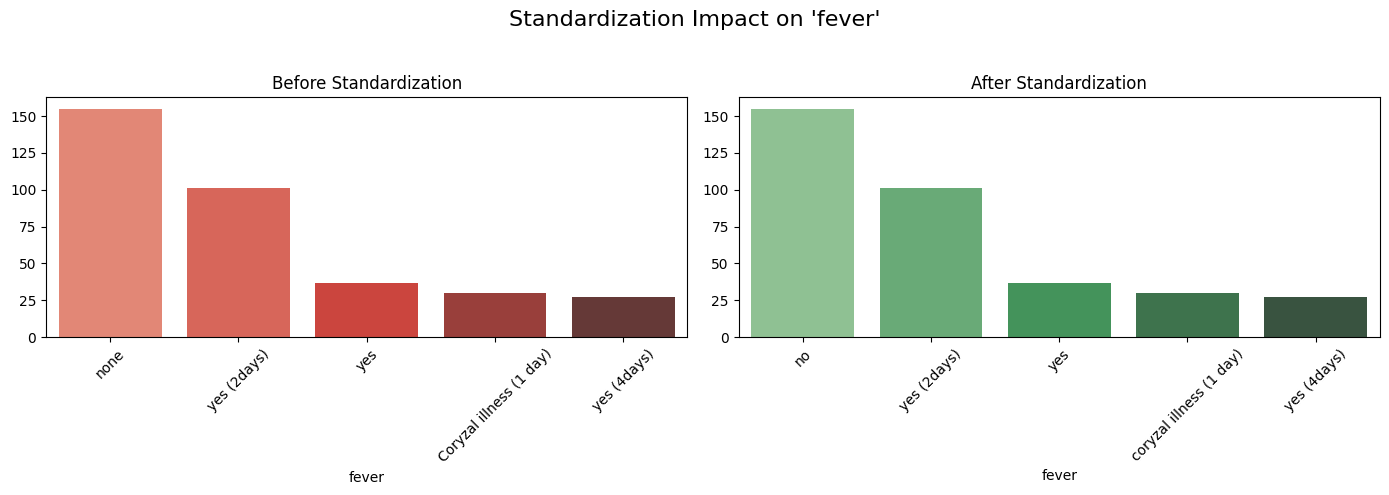


------------------------------------------------------------
🔎 Detailed Report for Column: 'headache'
   - Unique values reduced from 2 to 2.


,Before,After
headache,,
yes,271,271
none,79,0
no,0,79


/tmp/ipython-input-982147270.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=report['before_counts'].index, y=report['before_counts'].values, ax=axes[0], palette='Reds_d'); axes[0].set_title("Before Standardization"); axes[0].tick_params(axis='x', rotation=45)
/tmp/ipython-input-982147270.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=report['after_counts'].index, y=report['after_counts'].values, ax=axes[1], palette='Greens_d'); axes[1].set_title("After Standardization"); axes[1].tick_params(axis='x', rotation=45)


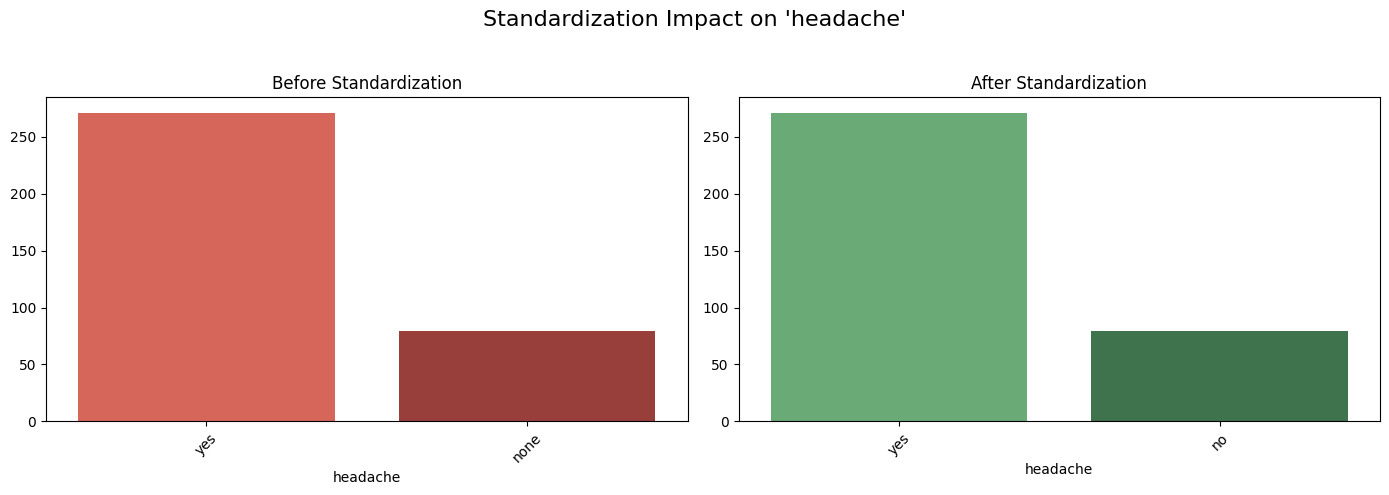


------------------------------------------------------------
🔎 Detailed Report for Column: 'myalgia'
   - Unique values reduced from 2 to 2.


,Before,After
myalgia,,
yes,280,280
none,70,0
no,0,70


/tmp/ipython-input-982147270.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=report['before_counts'].index, y=report['before_counts'].values, ax=axes[0], palette='Reds_d'); axes[0].set_title("Before Standardization"); axes[0].tick_params(axis='x', rotation=45)
/tmp/ipython-input-982147270.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=report['after_counts'].index, y=report['after_counts'].values, ax=axes[1], palette='Greens_d'); axes[1].set_title("After Standardization"); axes[1].tick_params(axis='x', rotation=45)


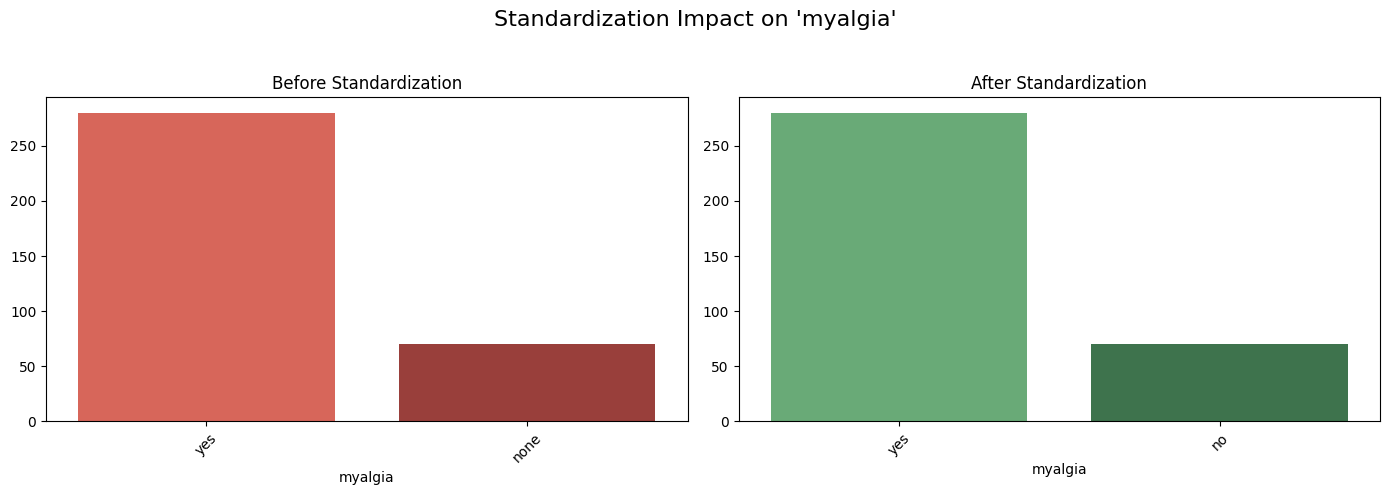


------------------------------------------------------------
🔎 Detailed Report for Column: 'back_pain'
   - Unique values reduced from 2 to 2.


,Before,After
back_pain,,
yes,240,240
none,110,0
no,0,110


/tmp/ipython-input-982147270.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=report['before_counts'].index, y=report['before_counts'].values, ax=axes[0], palette='Reds_d'); axes[0].set_title("Before Standardization"); axes[0].tick_params(axis='x', rotation=45)
/tmp/ipython-input-982147270.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=report['after_counts'].index, y=report['after_counts'].values, ax=axes[1], palette='Greens_d'); axes[1].set_title("After Standardization"); axes[1].tick_params(axis='x', rotation=45)


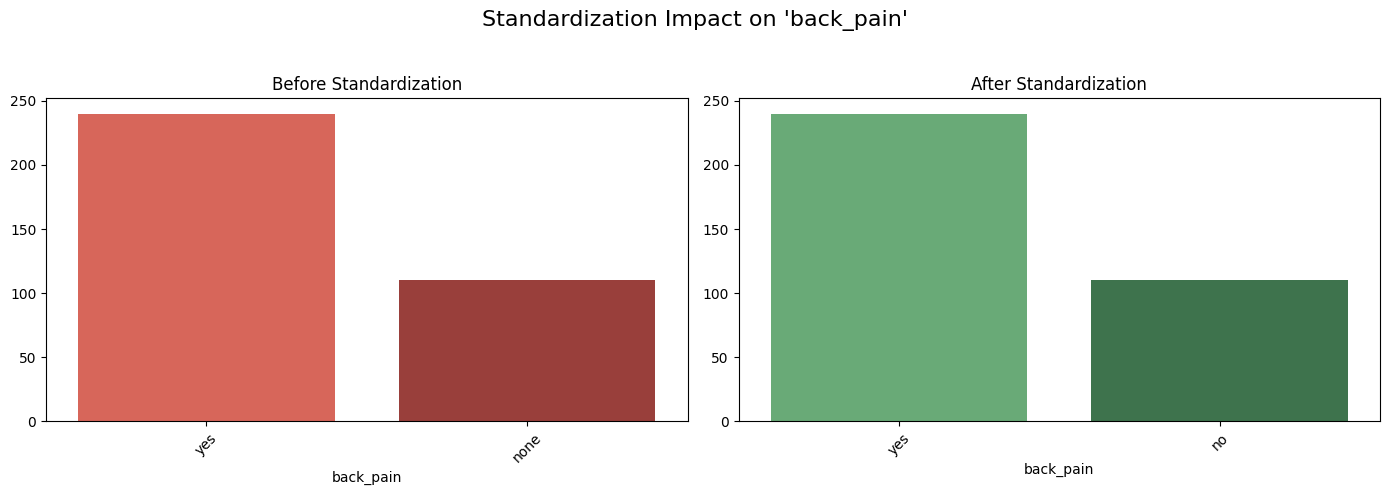


------------------------------------------------------------
🔎 Detailed Report for Column: 'chills'
   - Unique values reduced from 2 to 2.


,Before,After
chills,,
none,241,0
yes,109,109
no,0,241


/tmp/ipython-input-982147270.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=report['before_counts'].index, y=report['before_counts'].values, ax=axes[0], palette='Reds_d'); axes[0].set_title("Before Standardization"); axes[0].tick_params(axis='x', rotation=45)
/tmp/ipython-input-982147270.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=report['after_counts'].index, y=report['after_counts'].values, ax=axes[1], palette='Greens_d'); axes[1].set_title("After Standardization"); axes[1].tick_params(axis='x', rotation=45)


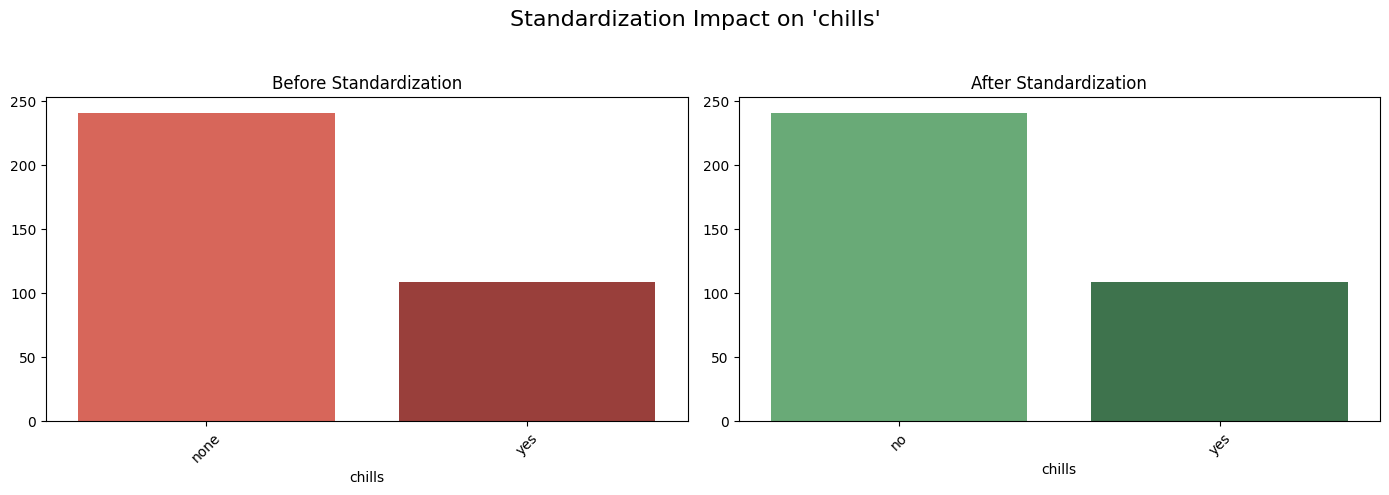


------------------------------------------------------------
🔎 Detailed Report for Column: 'sore_throat'
   - Unique values reduced from 2 to 2.


,Before,After
sore_throat,,
yes,254,254
none,96,0
no,0,96


/tmp/ipython-input-982147270.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=report['before_counts'].index, y=report['before_counts'].values, ax=axes[0], palette='Reds_d'); axes[0].set_title("Before Standardization"); axes[0].tick_params(axis='x', rotation=45)
/tmp/ipython-input-982147270.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=report['after_counts'].index, y=report['after_counts'].values, ax=axes[1], palette='Greens_d'); axes[1].set_title("After Standardization"); axes[1].tick_params(axis='x', rotation=45)


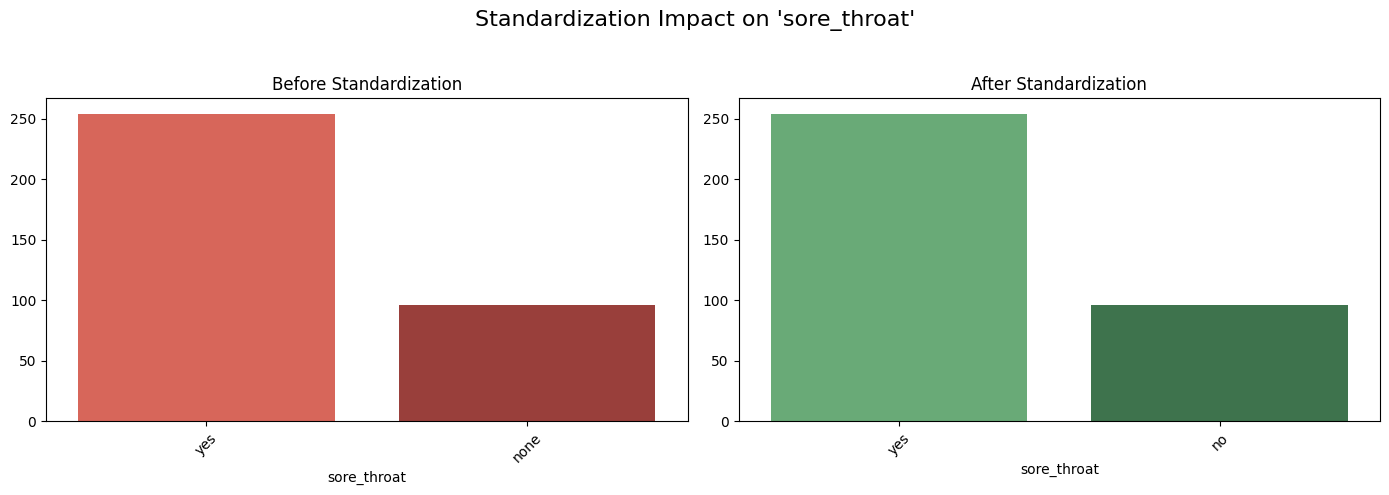


------------------------------------------------------------
🔎 Detailed Report for Column: 'lymphadenopathy'
   - Unique values reduced from 2 to 2.


,Before,After
lymphadenopathy,,
yes,228,228
none,122,0
no,0,122


/tmp/ipython-input-982147270.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=report['before_counts'].index, y=report['before_counts'].values, ax=axes[0], palette='Reds_d'); axes[0].set_title("Before Standardization"); axes[0].tick_params(axis='x', rotation=45)
/tmp/ipython-input-982147270.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=report['after_counts'].index, y=report['after_counts'].values, ax=axes[1], palette='Greens_d'); axes[1].set_title("After Standardization"); axes[1].tick_params(axis='x', rotation=45)


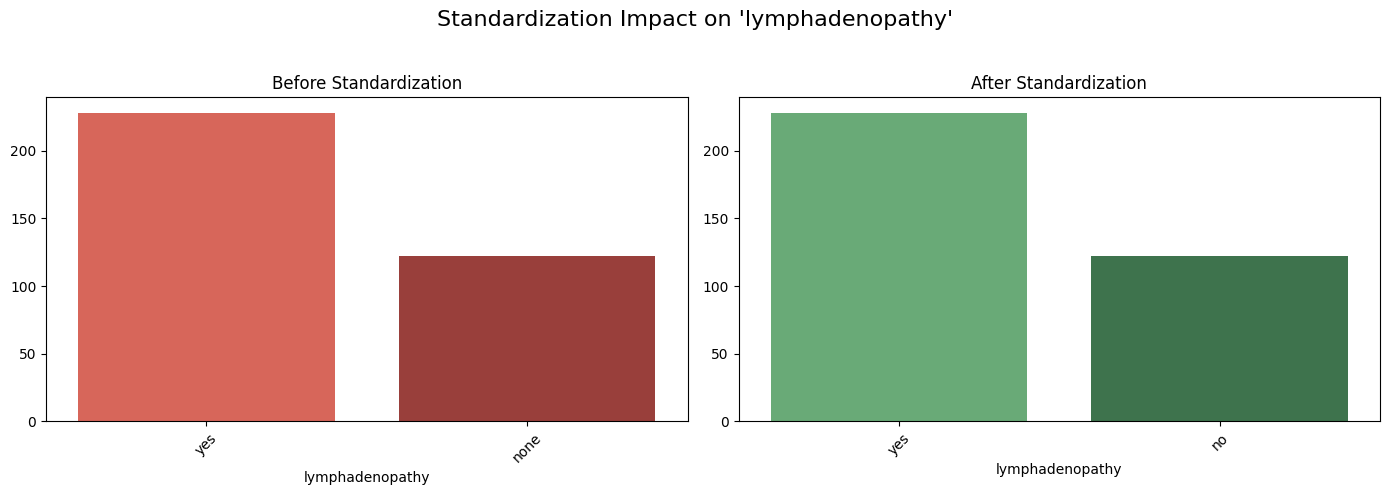


------------------------------------------------------------
🔎 Detailed Report for Column: 'dysuria'
   - Unique values reduced from 2 to 2.


,Before,After
dysuria,,
none,275,0
yes,75,75
no,0,275


/tmp/ipython-input-982147270.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=report['before_counts'].index, y=report['before_counts'].values, ax=axes[0], palette='Reds_d'); axes[0].set_title("Before Standardization"); axes[0].tick_params(axis='x', rotation=45)
/tmp/ipython-input-982147270.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=report['after_counts'].index, y=report['after_counts'].values, ax=axes[1], palette='Greens_d'); axes[1].set_title("After Standardization"); axes[1].tick_params(axis='x', rotation=45)


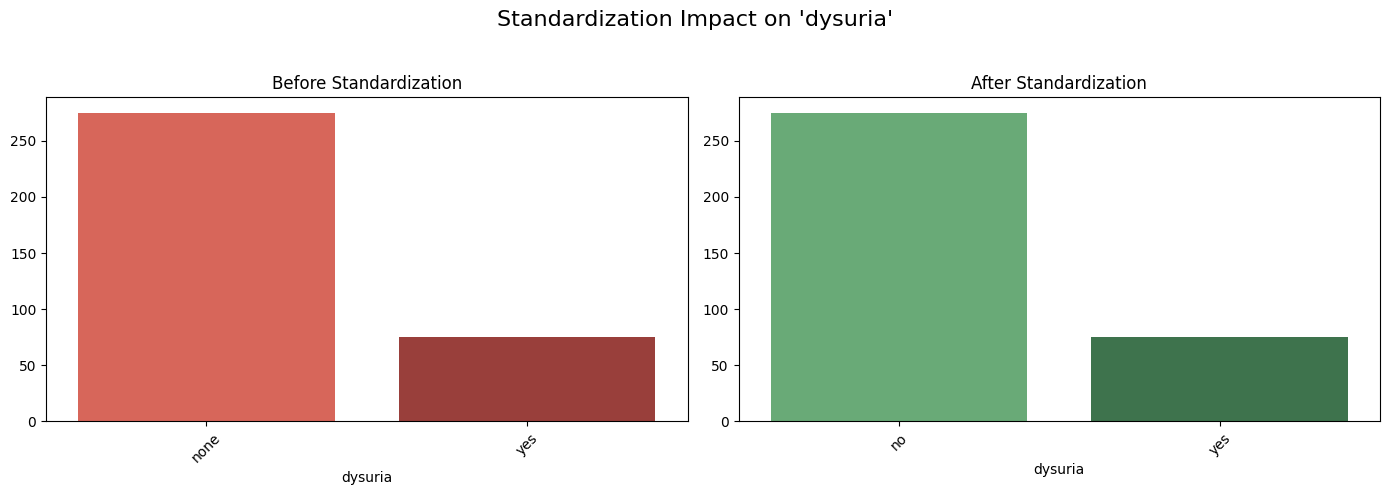


------------------------------------------------------------
🔎 Detailed Report for Column: 'rectal_pain_or_pain_on_defecation'
   - Unique values reduced from 2 to 2.


,Before,After
rectal_pain_or_pain_on_defecation,,
none,219,0
yes,131,131
no,0,219


/tmp/ipython-input-982147270.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=report['before_counts'].index, y=report['before_counts'].values, ax=axes[0], palette='Reds_d'); axes[0].set_title("Before Standardization"); axes[0].tick_params(axis='x', rotation=45)
/tmp/ipython-input-982147270.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=report['after_counts'].index, y=report['after_counts'].values, ax=axes[1], palette='Greens_d'); axes[1].set_title("After Standardization"); axes[1].tick_params(axis='x', rotation=45)


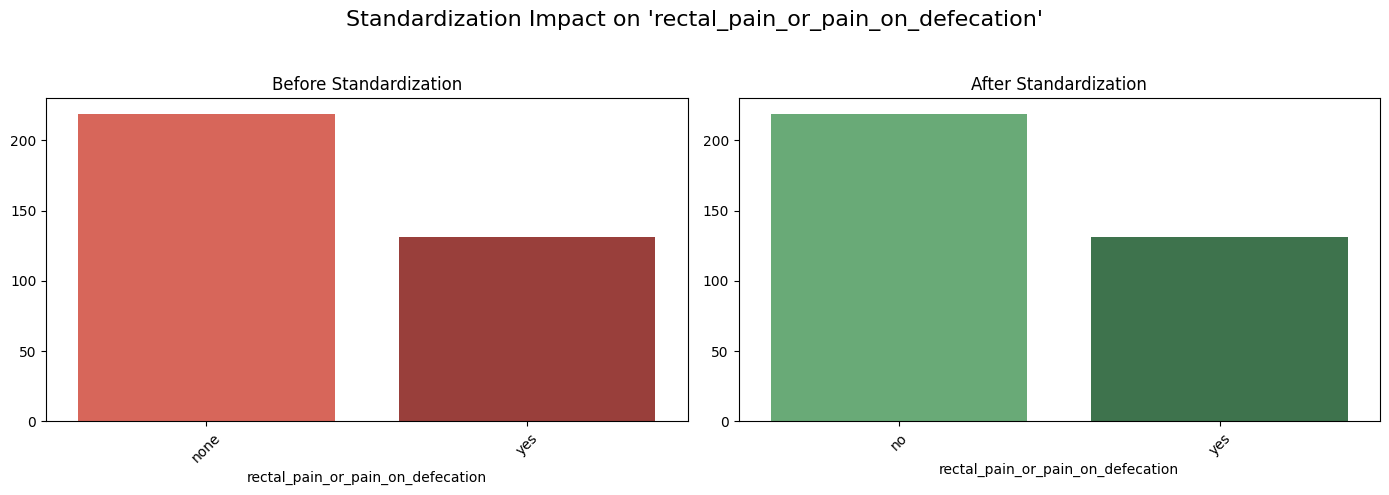


------------------------------------------------------------
🔎 Detailed Report for Column: 'bleeding_discharge_per_rectum'
   - Unique values reduced from 2 to 2.


,Before,After
bleeding_discharge_per_rectum,,
none,318,0
yes,32,32
no,0,318


/tmp/ipython-input-982147270.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=report['before_counts'].index, y=report['before_counts'].values, ax=axes[0], palette='Reds_d'); axes[0].set_title("Before Standardization"); axes[0].tick_params(axis='x', rotation=45)
/tmp/ipython-input-982147270.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=report['after_counts'].index, y=report['after_counts'].values, ax=axes[1], palette='Greens_d'); axes[1].set_title("After Standardization"); axes[1].tick_params(axis='x', rotation=45)


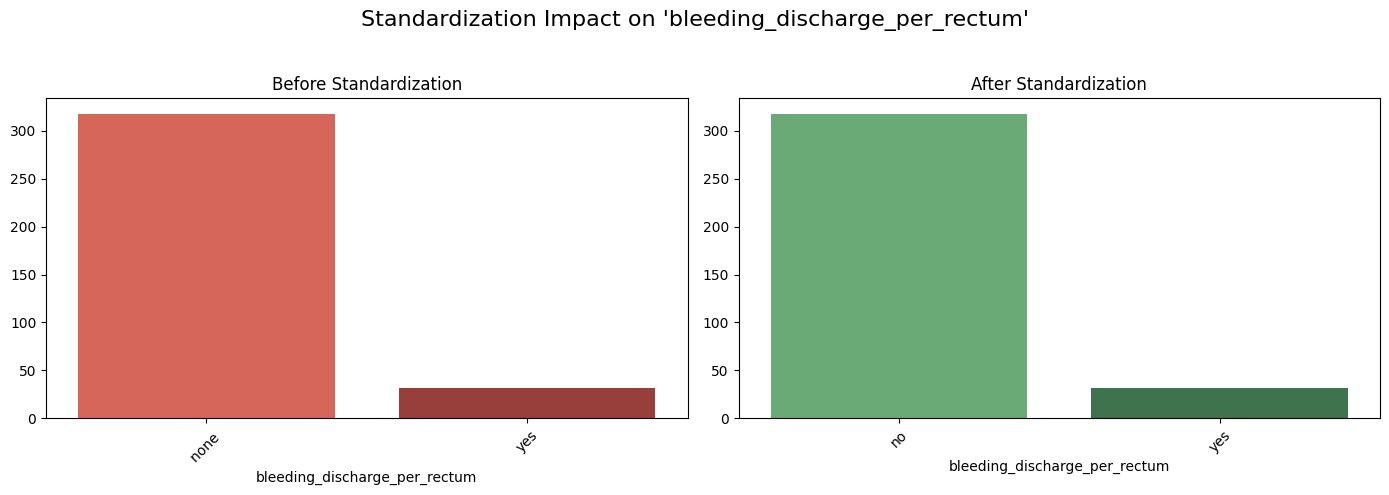


------------------------------------------------------------
🔎 Detailed Report for Column: 'conjunctivitis'
   - Unique values reduced from 2 to 2.


,Before,After
conjunctivitis,,
yes,178,178
none,172,0
no,0,172


/tmp/ipython-input-982147270.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=report['before_counts'].index, y=report['before_counts'].values, ax=axes[0], palette='Reds_d'); axes[0].set_title("Before Standardization"); axes[0].tick_params(axis='x', rotation=45)
/tmp/ipython-input-982147270.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=report['after_counts'].index, y=report['after_counts'].values, ax=axes[1], palette='Greens_d'); axes[1].set_title("After Standardization"); axes[1].tick_params(axis='x', rotation=45)


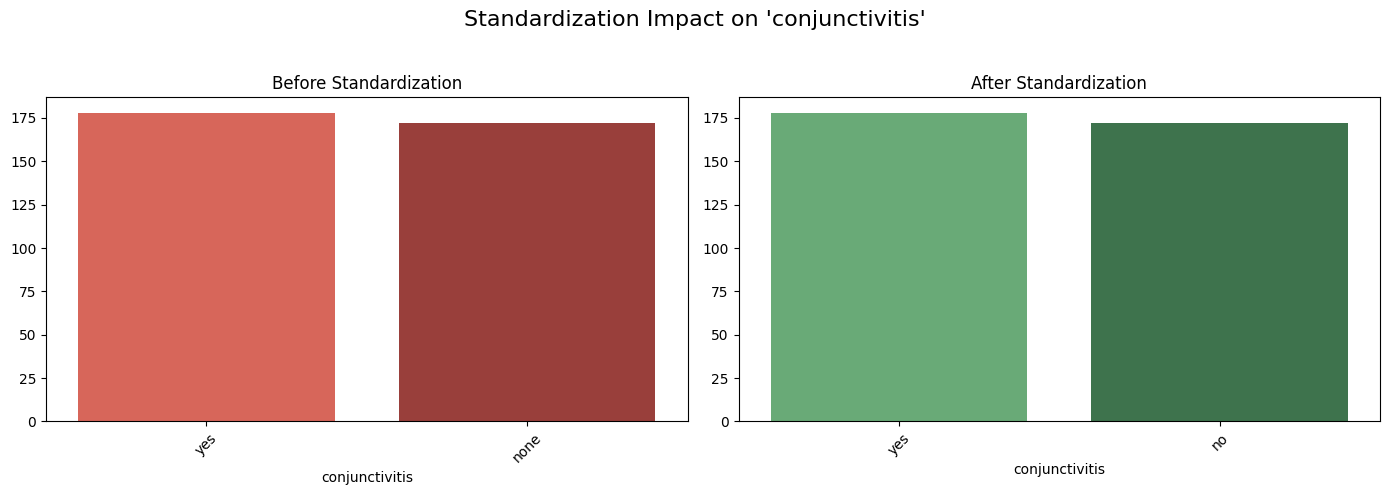


------------------------------------------------------------
🔎 Detailed Report for Column: 'sex'
   - Unique values reduced from 2 to 2.


,Before,After
sex,,
female,178,0
male,172,0
female,0,178
male,0,172


/tmp/ipython-input-982147270.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=report['before_counts'].index, y=report['before_counts'].values, ax=axes[0], palette='Reds_d'); axes[0].set_title("Before Standardization"); axes[0].tick_params(axis='x', rotation=45)
/tmp/ipython-input-982147270.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=report['after_counts'].index, y=report['after_counts'].values, ax=axes[1], palette='Greens_d'); axes[1].set_title("After Standardization"); axes[1].tick_params(axis='x', rotation=45)


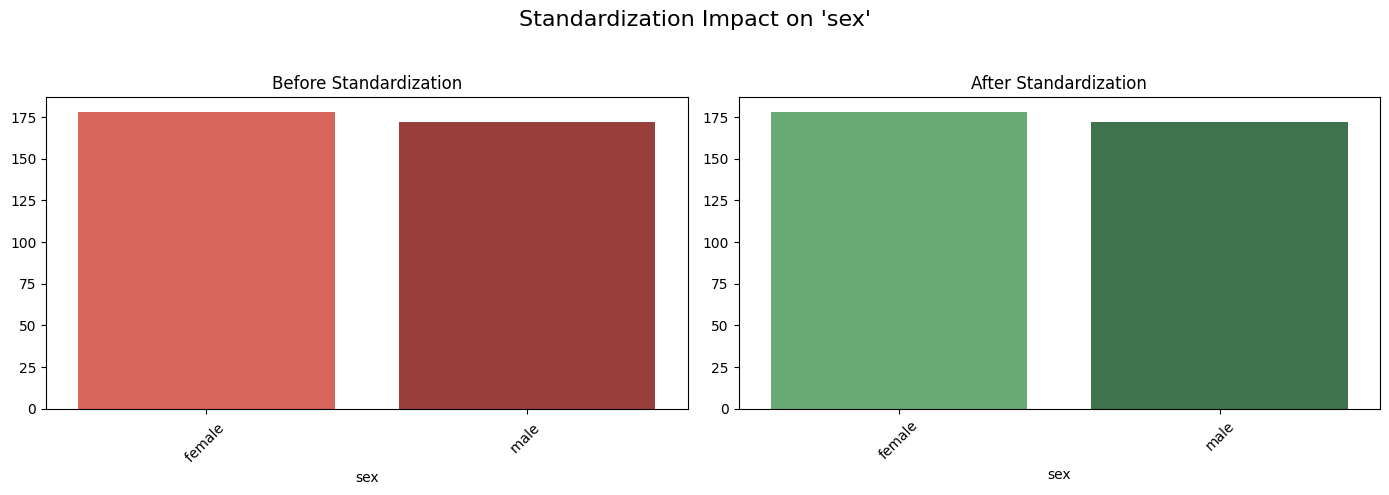


🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
STEP 4 SUCCESS: Categorical values have been consistently standardized across all data splits.
The data is now ready for missing value handling.
   - X_train_std shape: (350, 13)


In [4]:
# =============================================================================
# STEP 4: VALUE STANDARDIZATION
# =============================================================================
import pandas as pd  # Library manipulasi data
import numpy as np  # Library untuk operasi numerik
import matplotlib.pyplot as plt  # Library visualisasi
import seaborn as sns  # Library visualisasi
from IPython.display import display  # Menampilkan DataFrame dengan rapi di notebook

class ValueStandardizer:
    """
    Standardizes categorical values consistently across train, validation, and test sets
    with detailed, presentation-ready reporting.
    # Tujuan: Menghindari inkonsistensi kategori seperti "Yes"/"yes"/"Y"/"1" di seluruh dataset.
    """
    def __init__(self, X_train, X_validation, X_test):
        # Work on copies to avoid modifying original dataframes from previous steps
        self.X_train = X_train.copy()  # Copy data train
        self.X_validation = X_validation.copy()  # Copy data validation
        self.X_test = X_test.copy()  # Copy data test
        self.report_data = [] # Stores detailed change logs # Menyimpan perubahan untuk laporan visual

    def run_standardization(self):
        """Executes the entire standardization pipeline."""
        print("\n" + "✨"*40)
        print("STEP 4: STANDARDIZING CATEGORICAL VALUES")
        print("✨"*40)

        self._standardize_values()  # Terapkan standardisasi
        self._generate_report_and_visuals()  # Buat laporan dan visualisasi perubahan

        return self.X_train, self.X_validation, self.X_test  # Kembalikan dataset yang telah distandarisasi

    def _standardize_values(self):
        """Applies cleaning and standardization rules to all three data splits."""
        print("1. Cleaning and standardizing values in Train, Validation, and Test sets...")

        # Define comprehensive mapping rules for standardization
        replace_map = {
            'y': 'yes', 'true': 'yes', '1': 'yes', 'positive': 'yes', 'present': 'yes', 'detected': 'yes',  # Semua format 'yes'
            'n': 'no', 'false': 'no', '0': 'no', 'negative': 'no', 'absent': 'no', 'not detected': 'no', 'none': 'no',  # Semua format 'no'
            'm': 'male', 'man': 'male',  # Gender male
            'f': 'female', 'woman': 'female',  # Gender female
            'na': 'unknown', 'n/a': 'unknown', 'not specified': 'unknown', '?': 'unknown'  # Nilai tidak diketahui
        }

        # Identify categorical columns from the training set
        categorical_cols = self.X_train.select_dtypes(include=['object', 'category']).columns  # Deteksi kolom kategori

        # Apply the same transformations consistently to all three sets
        for df in [self.X_train, self.X_validation, self.X_test]:
            for col in categorical_cols:
                if col in df.columns:
                    # Capture state BEFORE for the training set report
                    if df is self.X_train:
                        before_counts = df[col].value_counts()  # Hitung distribusi awal

                    # Apply cleaning (strip whitespace, lowercase) and then replace using the map
                    df[col] = df[col].astype(str).str.strip().str.lower().replace(replace_map)  # Bersihkan dan standar

                    # Capture state AFTER for the training set report
                    if df is self.X_train:
                        after_counts = df[col].value_counts()  # Hitung distribusi setelah standar
                        # If any changes occurred, log them for the report
                        if not before_counts.equals(after_counts):
                            self.report_data.append({
                                'column': col,  # Nama kolom
                                'before_counts': before_counts,  # Distribusi sebelum standar
                                'after_counts': after_counts,  # Distribusi sesudah standar
                                'unique_before': len(before_counts),  # Jumlah nilai unik awal
                                'unique_after': len(after_counts)  # Jumlah nilai unik akhir
                            })

        print(f"   ✅ Standardization rules applied to {len(categorical_cols)} categorical columns.")  # Laporan jumlah kolom

    def _generate_report_and_visuals(self):
        """Generates a detailed, visual report of the standardization on the training set."""
        print("\n" + "📋"*40)
        print("COMPREHENSIVE STANDARDIZATION REPORT (Based on Training Set)")
        print("📋"*40)

        if not self.report_data:
            print("✅ No values required standardization. All categorical data is already clean.")  # Tidak ada perubahan
            return

        print(f"Found {len(self.report_data)} column(s) with values that were standardized.")  # Jumlah kolom yang berubah

        for report in self.report_data:
            col, before_df, after_df = report['column'], report['before_counts'].to_frame('Before'), report['after_counts'].to_frame('After')
            comparison_df = pd.concat([before_df, after_df], axis=1).fillna(0).astype(int)  # Gabungkan tabel before/after

            print("\n" + "-"*60)
            print(f"🔎 Detailed Report for Column: '{col}'")
            print(f"   - Unique values reduced from {report['unique_before']} to {report['unique_after']}.")  # Info ringkas
            display(comparison_df)  # Tampilkan tabel before/after

            # Create side-by-side visualizations
            fig, axes = plt.subplots(1, 2, figsize=(14, 5)); fig.suptitle(f"Standardization Impact on '{col}'", fontsize=16)
            sns.barplot(x=report['before_counts'].index, y=report['before_counts'].values, ax=axes[0], palette='Reds_d'); axes[0].set_title("Before Standardization"); axes[0].tick_params(axis='x', rotation=45)
            sns.barplot(x=report['after_counts'].index, y=report['after_counts'].values, ax=axes[1], palette='Greens_d'); axes[1].set_title("After Standardization"); axes[1].tick_params(axis='x', rotation=45)
            plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()  # Visualisasi per kolom

# =============================================================================
# EXECUTION FOR STEP 4
# =============================================================================
# This step runs AFTER Step 3 (Data Splitting)
if 'X_train' in locals():
    print("\n" + "="*80)
    print("🚀 STARTING STEP 4: VALUE STANDARDIZATION")
    print("="*80)

    # Initialize the standardizer with the three data splits
    standardizer = ValueStandardizer(X_train, X_validation, X_test)  # Inisialisasi class

    # Run the process
    X_train_std, X_validation_std, X_test_std = standardizer.run_standardization()  # Jalankan standardisasi

    print("\n" + "🎉"*60)
    print("STEP 4 SUCCESS: Categorical values have been consistently standardized across all data splits.")  # Konfirmasi sukses
    print("The data is now ready for missing value handling.")  # Next step
    print(f"   - X_train_std shape: {X_train_std.shape}")  # Ukuran dataset
    print("="*80)
else:
    print("🛑 Could not run Step 4 because the split data (`X_train`, etc.) from Step 3 was not found.")  # Error handling


In [5]:
# =============================================================================
# STEP 5: MISSING VALUE HANDLING (FINAL REVISION WITH SYNTAX FIX)
# =============================================================================
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

class ComprehensiveMissingValueHandler:
    """
    Analyzes missing values, then imputes them correctly on pre-split data
    using a revised logic to prevent data leakage.
    """
    def __init__(self):
        self.imputation_plan = None
        self.num_imputer = SimpleImputer(strategy='median')
        self.cat_imputer = SimpleImputer(strategy='most_frequent')
        self.num_cols_to_impute = []
        self.cat_cols_to_impute = []

    def run_pipeline(self, df_original, X_train, X_validation, X_test):
        """Executes the full analysis and imputation pipeline."""
        self._analyze_missing_values(X_train) # Analisis sebaiknya dilakukan di data train untuk konsistensi

        if self.imputation_plan is None or self.imputation_plan.empty:
            print("✅ No missing values to impute. Returning original data sets.")
            return X_train, X_validation, X_test

        return self._execute_imputation(X_train, X_validation, X_test)

    def _analyze_missing_values(self, df):
        """Performs analysis on the training data to generate an imputation plan."""
        print("\n" + "📊"*40)
        print("PART 1: DEEP ANALYSIS OF MISSING VALUES (PLANNING STAGE ON TRAINING DATA)")
        print("📊"*40)
        missing = df.isnull().sum()
        missing = missing[missing > 0]
        if missing.empty:
            self.imputation_plan = pd.DataFrame()
            return

        print(f"Found {len(missing)} columns with missing values. Generating analysis and strategy plan...")
        plan_details = [{'Column': col, 'Missing Count': count, 'Missing (%)': f"{(count / len(df)) * 100:.1f}%",
                         'Data Type': str(df[col].dtype), 'Recommended Strategy': "Median" if pd.api.types.is_numeric_dtype(df[col]) else "Mode"}
                        for col, count in missing.items()]
        self.imputation_plan = pd.DataFrame(plan_details).sort_values(by='Missing Count', ascending=False)
        print("\n📋 Imputation Plan Summary:")
        display(self.imputation_plan.style.background_gradient(cmap='Reds', subset=['Missing Count']))
        self._create_advanced_missing_visualizations(df)

    def _create_advanced_missing_visualizations(self, df):
        # Fungsi ini tidak perlu diubah
        print("\n📈 Generating Advanced Missing Value Visualizations...")
        fig, axes = plt.subplots(1, 2, figsize=(16, 6)); fig.suptitle('Missing Values Analysis on Training Data', fontsize=16)
        missing_df = self.imputation_plan
        sns.heatmap(df[missing_df['Column']].isnull(), cbar=False, cmap='viridis_r', ax=axes[0]); axes[0].set_title('Missing Values Heatmap Pattern')
        top_10 = missing_df.head(10); sns.barplot(x='Missing Count', y='Column', data=top_10, ax=axes[1], palette='viridis'); axes[1].set_title('Top 10 Columns with Missing Values')
        plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()

    def _execute_imputation(self, X_train, X_validation, X_test):
        """
        Executes the imputation using the correct anti-data leakage workflow.
        """
        print("\n" + "⚡"*40)
        print("PART 2: EXECUTING IMPUTATION ON SPLIT DATA (CORRECT LOGIC)")
        print("⚡"*40)

        self.num_cols_to_impute = self.imputation_plan[self.imputation_plan['Recommended Strategy'] == 'Median']['Column'].tolist()
        self.cat_cols_to_impute = self.imputation_plan[self.imputation_plan['Recommended Strategy'] == 'Mode']['Column'].tolist()

        self.num_cols_to_impute = [col for col in self.num_cols_to_impute if col in X_train.columns]
        self.cat_cols_to_impute = [col for col in self.cat_cols_to_impute if col in X_train.columns]

        X_train_imputed, X_validation_imputed, X_test_imputed = X_train.copy(), X_validation.copy(), X_test.copy()

        print("1. Fitting imputers ONLY on the TRAINING data...")
        if self.num_cols_to_impute:
            self.num_imputer.fit(X_train[self.num_cols_to_impute])
        if self.cat_cols_to_impute:
            self.cat_imputer.fit(X_train[self.cat_cols_to_impute])

        print("2. Transforming TRAIN, VALIDATION, and TEST data separately...")
        if self.num_cols_to_impute:
            X_train_imputed[self.num_cols_to_impute] = self.num_imputer.transform(X_train[self.num_cols_to_impute])
            X_validation_imputed[self.num_cols_to_impute] = self.num_imputer.transform(X_validation[self.num_cols_to_impute])
            X_test_imputed[self.num_cols_to_impute] = self.num_imputer.transform(X_test[self.num_cols_to_impute])
        if self.cat_cols_to_impute:
            X_train_imputed[self.cat_cols_to_impute] = self.cat_imputer.transform(X_train[self.cat_cols_to_impute])
            X_validation_imputed[self.cat_cols_to_impute] = self.cat_imputer.transform(X_validation[self.cat_cols_to_impute])
            X_test_imputed[self.cat_cols_to_impute] = self.cat_imputer.transform(X_test[self.cat_cols_to_impute])

        self._generate_imputation_report(X_train_imputed, X_validation_imputed, X_test_imputed)
        return X_train_imputed, X_validation_imputed, X_test_imputed

    def _generate_imputation_report(self, X_train, X_validation, X_test):
        # Perbaikan di sini, menghapus '90' yang salah
        print("\n" + "📋"*40); print("PART 3: IMPUTATION EXECUTION REPORT"); print("📋"*40)
        print("\nFinal Verification:")
        print(f"   - Missing values remaining in X_train: {X_train.isnull().sum().sum()}")
        print(f"   - Missing values in X_validation: {X_validation.isnull().sum().sum()}")
        print(f"   - Missing values in X_test: {X_test.isnull().sum().sum()}")
        if X_train.isnull().sum().sum() == 0:
            print("   - ✅ SUCCESS. All missing values have been handled correctly.")
        else:
            print("   - ⚠️ WARNING. Some missing values remain.")

# =============================================================================
# EXECUTION FOR STEP 5
# =============================================================================
if 'X_train_std' in locals():
    print("\n" + "="*80)
    print("🚀 STARTING STEP 5: MISSING VALUE ANALYSIS & HANDLING")
    print("="*80)

    handler = ComprehensiveMissingValueHandler()

    # Menjalankan pipeline dengan input yang benar
    X_train_imputed, X_validation_imputed, X_test_imputed = handler.run_pipeline(
        df_final_step2, X_train_std, X_validation_std, X_test_std
    )

    print("\n" + "🎉"*60)
    print("STEP 5 SUCCESS: Missing values have been handled correctly across all data splits.")
    print("="*80)
else:
    print("🛑 Could not run Step 5 because the standardized data (`X_train_std`, etc.) from Step 4 was not found.")


🚀 STARTING STEP 5: MISSING VALUE ANALYSIS & HANDLING

📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊
PART 1: DEEP ANALYSIS OF MISSING VALUES (PLANNING STAGE ON TRAINING DATA)
📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊
✅ No missing values to impute. Returning original data sets.

🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
STEP 5 SUCCESS: Missing values have been handled correctly across all data splits.


<details>
<summary>📖 Penjelasan Step 6: Feature Engineering, Encoding, & Scaling</summary>

**Step 6** adalah tahap final preprocessing sebelum model training. Berikut rinciannya:

---

### 🔹 6.1 Feature Engineering
- Membuat fitur baru berdasarkan domain knowledge:
  - `symptom_score`: jumlah gejala 'yes' yang dialami pasien.
  - `symptom_severity`: kategori keparahan gejala berdasarkan kuantil train set.
  - `age_group`: kelompok umur berdasarkan batas tertentu (0–18, 19–40, 41–65, 66+).
- Semua fitur baru diterapkan konsisten ke **train, validation, dan test set**.

### 🔹 6.2 Encoding & Handling Cardinality
- Pisahkan kolom kategori menjadi:
  - **Low-cardinality (≤10 unique values)** → One-Hot Encoding (OHE).
  - **High-cardinality (>10 unique values)** → dihapus untuk menghindari sparsity.
- OHE **fit hanya di train set**, lalu transform diterapkan ke semua split.
- Menjamin tidak terjadi data leakage.

### 🔹 6.3 Scaling Numerical Features
- Semua fitur numerik di-scale menggunakan **StandardScaler**:
  - Fit hanya di train set.
  - Transform diterapkan ke train, validation, dan test set.
- Menjaga skala fitur agar model tidak bias terhadap range numerik tertentu.
- Statistik sebelum & sesudah scaling ditampilkan untuk monitoring.

### 🔹 6.4 Final Report
- Menampilkan shape final untuk **X_train_final, X_validation_final, X_test_final**.
- Menyediakan preview data train yang sudah siap untuk model training.

---

✅ Setelah Step 6, data sudah:
- Bebas missing values.
- Fitur kategori & numerik sudah siap.
- Split data konsisten untuk train, validation, dan test.
- Siap untuk proses model building atau evaluasi.

</details>


In [6]:
# =============================================================================
# STEP 6: FEATURE ENGINEERING, ENCODING, & SCALING (REVISED WITH ERROR FIX)
# =============================================================================
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pandas as pd
import numpy as np
from IPython.display import display

class FeaturePipeline:
    def __init__(self, X_train, X_validation, X_test):
        self.X_train = X_train.copy()
        self.X_validation = X_validation.copy()
        self.X_test = X_test.copy()
        self.learned_params = {}
        self.report = {}

    def run_pipeline(self):
        print("\n" + "🛠️"*40)
        print("STEP 6: FEATURE ENGINEERING, ENCODING, AND SCALING")
        print("🛠️"*40)

        self._engineer_features()
        self._encode_and_handle_cardinality()
        self._scale_numerical_features()
        self._generate_final_report()

        return self.X_train, self.X_validation, self.X_test

    def _engineer_features(self):
        print("\n--- 6.1: Engineering New Features ---")

        # =============================================================================
        # === FUNGSI DENGAN PERBAIKAN UNTUK MENGATASI ERROR 'Bin edges must be unique' ===
        # =============================================================================
        def create_features(df, params, is_train=False):
            symptom_cols = ['chills', 'sore_throat', 'rectal_pain_or_pain_on_defecation', 'headache', 'myalgia']
            symptom_cols_exist = [c for c in symptom_cols if c in df.columns]

            if symptom_cols_exist:
                df['symptom_score'] = df[symptom_cols_exist].apply(lambda row: sum(1 for val in row if str(val) == 'yes'), axis=1)

                if is_train:
                    # Simpan kuantil dari train set
                    params['symptom_quantiles'] = df['symptom_score'].quantile([0.33, 0.66]).tolist()

                quantiles = params.get('symptom_quantiles', [0, 0])

                # [FIX] Buat daftar batas (bins) dan pastikan unik
                bins = [-np.inf, quantiles[0], quantiles[1], np.inf]
                unique_bins = sorted(list(set(bins)))

                # [FIX] Buat label secara dinamis berdasarkan jumlah batas yang unik
                labels = range(len(unique_bins) - 1)

                if len(labels) > 0:
                    df['symptom_severity'] = pd.cut(df['symptom_score'], bins=unique_bins, labels=labels, include_lowest=True).astype(int)
                else: # Jika semua nilai sama, berikan satu kategori saja
                    df['symptom_severity'] = 0


            if 'age' in df.columns:
                df['age_group'] = pd.cut(df['age'], bins=[0, 18, 40, 65, np.inf], labels=[0, 1, 2, 3], include_lowest=True, duplicates='drop').astype(int)

            return df
        # =============================================================================

        self.X_train = create_features(self.X_train, self.learned_params, is_train=True)
        self.X_validation = create_features(self.X_validation, self.learned_params)
        self.X_test = create_features(self.X_test, self.learned_params)

        new_features = [col for col in ['symptom_score', 'symptom_severity', 'age_group'] if col in self.X_train.columns]
        self.report['engineered_features'] = new_features
        print(f"   ✅ Created {len(new_features)} new features: {new_features}")

    def _encode_and_handle_cardinality(self):
        print("\n--- 6.2: Encoding Categorical Features ---")
        categorical_cols = self.X_train.select_dtypes(include=['object', 'category']).columns.tolist()

        # Menggunakan drop='first' adalah praktik terbaik untuk menghindari multikolinearitas
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=np.int8, drop='first')
        ohe.fit(self.X_train[categorical_cols])

        def encode_df(df, encoder, columns_to_encode):
            encoded_df = pd.DataFrame(encoder.transform(df[columns_to_encode]), columns=encoder.get_feature_names_out(), index=df.index)
            df_dropped = df.drop(columns=columns_to_encode)
            return pd.concat([df_dropped, encoded_df], axis=1)

        self.X_train = encode_df(self.X_train, ohe, categorical_cols)
        self.X_validation = encode_df(self.X_validation, ohe, categorical_cols)
        self.X_test = encode_df(self.X_test, ohe, categorical_cols)
        print(f"   - Applied One-Hot Encoding to {len(categorical_cols)} columns.")

    def _scale_numerical_features(self):
        print("\n--- 6.3: Scaling Numerical Features ---")
        numerical_cols = self.X_train.select_dtypes(include=np.number).columns.tolist()
        if not numerical_cols:
            print("   - No numerical features to scale.")
            return

        scaler = StandardScaler()
        scaler.fit(self.X_train[numerical_cols])

        self.X_train[numerical_cols] = scaler.transform(self.X_train[numerical_cols])
        self.X_validation[numerical_cols] = scaler.transform(self.X_validation[numerical_cols])
        self.X_test[numerical_cols] = scaler.transform(self.X_test[numerical_cols])
        print(f"   - Applied StandardScaler to {len(numerical_cols)} numerical features.")

    def _generate_final_report(self):
        print("\n" + "📋"*40); print("FINAL REPORT FOR STEP 6"); print("📋"*40)
        print("\nFinal Data Shapes:")
        print(f"   - Processed Training Features (X_train_final): {self.X_train.shape}")
        print(f"   - Processed Validation Features (X_validation_final): {self.X_validation.shape}")
        print(f"   - Processed Testing Features (X_test_final):   {self.X_test.shape}")

# =============================================================================
# EXECUTION FOR STEP 6
# =============================================================================
if 'X_train_imputed' in locals():
    print("\n" + "="*80); print("🚀 STARTING STEP 6: FEATURE ENGINEERING, ENCODING, & SCALING"); print("="*80)

    pipeline = FeaturePipeline(X_train_imputed, X_validation_imputed, X_test_imputed)
    X_train_final, X_validation_final, X_test_final = pipeline.run_pipeline()

    print("\n" + "🏁"*60); print("ENTIRE PREPROCESSING PIPELINE IS COMPLETE!"); print("🏁"*60)
    print("The following data is now 100% ready for training and evaluation.")
    display(X_train_final.head())
    print("="*80)
else:
    print("🛑 Could not run Step 6 because the imputed data from Step 5 was not found.")


🚀 STARTING STEP 6: FEATURE ENGINEERING, ENCODING, & SCALING

🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️
STEP 6: FEATURE ENGINEERING, ENCODING, AND SCALING
🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️

--- 6.1: Engineering New Features ---
   ✅ Created 3 new features: ['symptom_score', 'symptom_severity', 'age_group']

--- 6.2: Encoding Categorical Features ---
   - Applied One-Hot Encoding to 12 columns.

--- 6.3: Scaling Numerical Features ---
   - Applied StandardScaler to 19 numerical features.

📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋
FINAL REPORT FOR STEP 6
📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋

Final Data Shapes:
   - Processed Training Features (X_train_final): (350, 19)
   - Processed Validation Features (X_validation_final): (75, 19)
   - Processed Testing Features (X_test_final):   (75, 19)

🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁
ENTIRE PREPROCESSING PIPELINE IS COMPLETE!
🏁🏁🏁🏁🏁

,age,symptom_score,symptom_severity,age_group,fever_no,fever_yes,fever_yes (2days),fever_yes (4days),headache_yes,myalgia_yes,back_pain_yes,chills_yes,sore_throat_yes,lymphadenopathy_yes,dysuria_yes,rectal_pain_or_pain_on_defecation_yes,bleeding_discharge_per_rectum_yes,conjunctivitis_yes,sex_male
170,-0.029077,-0.726155,-0.982779,0.358099,1.121635,-0.343818,-0.636885,-0.289122,0.539919,0.5,0.677003,-0.672519,-1.626602,0.731497,-0.522233,-0.773417,-0.317221,-1.017292,-0.983002
142,-1.574935,-0.726155,-0.982779,-1.540909,1.121635,-0.343818,-0.636885,-0.289122,0.539919,0.5,0.677003,-0.672519,-1.626602,0.731497,-0.522233,-0.773417,-0.317221,-1.017292,-0.983002
88,0.400328,1.483882,1.414243,0.358099,-0.891556,-0.343818,1.570142,-0.289122,0.539919,0.5,-1.477098,1.486946,0.614779,0.731497,-0.522233,1.292964,-0.317221,0.983002,1.017292
105,0.529150,-0.726155,-0.982779,0.358099,1.121635,-0.343818,-0.636885,-0.289122,0.539919,0.5,0.677003,-0.672519,-1.626602,0.731497,-0.522233,-0.773417,-0.317221,-1.017292,-0.983002
352,-1.317292,-0.726155,-0.982779,-1.540909,-0.891556,-0.343818,-0.636885,-0.289122,0.539919,-2.0,0.677003,-0.672519,0.614779,-1.367060,1.914854,-0.773417,-0.317221,-1.017292,1.017292


In [7]:
# =============================================================================
# DIAGNOSTIC STEP: CHECK FOR TARGET LEAKAGE
# =============================================================================

print("🔬 Menganalisis kolom di dalam X_train_final untuk mencari kebocoran target...")

# Cetak semua nama kolom yang akan masuk ke model
all_columns = X_train_final.columns.tolist()
print("\nTotal columns:", len(all_columns))
print(all_columns)

# Coba cari nama kolom yang mencurigakan (sesuaikan dengan nama kolom target Anda)
suspicious_cols = [col for col in all_columns if 'positive' in col.lower() or 'negative' in col.lower() or 'monkeypox' in col.lower()]

if suspicious_cols:
    print("\n" + "🚨"*20)
    print("WARNING: DITEMUKAN KOLOM YANG SANGAT MENCURIGAKAN!")
    print("Kolom berikut kemungkinan adalah target yang bocor ke dalam fitur:")
    print(suspicious_cols)
    print("🚨"*20)
else:
    print("\n✅ Tidak ditemukan nama kolom target yang jelas di dalam fitur.")

🔬 Menganalisis kolom di dalam X_train_final untuk mencari kebocoran target...

Total columns: 19
['age', 'symptom_score', 'symptom_severity', 'age_group', 'fever_no', 'fever_yes', 'fever_yes (2days)', 'fever_yes (4days)', 'headache_yes', 'myalgia_yes', 'back_pain_yes', 'chills_yes', 'sore_throat_yes', 'lymphadenopathy_yes', 'dysuria_yes', 'rectal_pain_or_pain_on_defecation_yes', 'bleeding_discharge_per_rectum_yes', 'conjunctivitis_yes', 'sex_male']

✅ Tidak ditemukan nama kolom target yang jelas di dalam fitur.


In [8]:
# =============================================================================
# STEP 7: ENCODING THE TARGET VARIABLE
# =============================================================================
from sklearn.preprocessing import LabelEncoder

print("\n" + "🎯"*40)
print("STEP 7: ENCODING THE TARGET VARIABLE (y)")
print("🎯"*40)

# 1. Inisialisasi LabelEncoder
le = LabelEncoder()

# 2. Fit encoder HANYA pada y_train dan transform semuanya
# Ini memastikan mapping yang konsisten di semua set data
y_train_encoded = le.fit_transform(y_train)
y_validation_encoded = le.transform(y_validation)
y_test_encoded = le.transform(y_test)

# 3. Tampilkan mapping yang dipelajari oleh encoder
print("Label Encoder has learned the following mapping:")
for index, label in enumerate(le.classes_):
    print(f"   - '{label}'  ->  {index}")
    if label == 'positive':
        positive_class_index = index

print(f"\n✅ Target variable has been encoded. The positive class ('positive') is now represented by the number {positive_class_index}.")
print(f"   - y_train_encoded shape: {y_train_encoded.shape}")


🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯
STEP 7: ENCODING THE TARGET VARIABLE (y)
🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯
Label Encoder has learned the following mapping:
   - 'negative'  ->  0
   - 'positive'  ->  1

✅ Target variable has been encoded. The positive class ('positive') is now represented by the number 1.
   - y_train_encoded shape: (350,)


In [9]:
# =============================================================================
# STEP 7A: ADDRESS CLASS IMBALANCE WITH SMOTE (FIXED)
# =============================================================================
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd # Pastikan pandas di-import

print("\\n" + "⚖️"*40)
print("STEP 7A: BALANCING THE TRAINING DATASET USING SMOTE")
print("⚖️"*40)

# Inisialisasi SMOTE. `random_state` digunakan untuk hasil yang reproduktif.
smote = SMOTE(random_state=42)

# Simpan nama kolom sebelum diubah menjadi array numpy
X_train_cols = X_train_final.columns

# Tampilkan distribusi kelas sebelum SMOTE
print("Distribusi kelas sebelum SMOTE:")
# FIX: Ubah numpy.ndarray menjadi pandas.Series untuk menggunakan value_counts()
print(pd.Series(y_train_encoded).value_counts())

# Terapkan SMOTE HANYA pada data training (X_train_final dan y_train_encoded)
# PENTING: Jangan pernah menerapkan SMOTE pada data validasi atau tes!
X_train_smote, y_train_smote = smote.fit_resample(X_train_final, y_train_encoded)

# Ubah kembali X_train_smote menjadi DataFrame dengan nama kolom yang benar
X_train_smote = pd.DataFrame(X_train_smote, columns=X_train_cols)

print("\\nDistribusi kelas setelah SMOTE:")
# FIX: Ubah juga y_train_smote (yang juga numpy array) menjadi pandas.Series
print(pd.Series(y_train_smote).value_counts())

print(f"\\n✅ Data training telah diseimbangkan. Ukuran baru X_train_smote: {X_train_smote.shape}")
print("="*80)

\n⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️
STEP 7A: BALANCING THE TRAINING DATASET USING SMOTE
⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️⚖️
Distribusi kelas sebelum SMOTE:
1    208
0    142
Name: count, dtype: int64
\nDistribusi kelas setelah SMOTE:
0    208
1    208
Name: count, dtype: int64
\n✅ Data training telah diseimbangkan. Ukuran baru X_train_smote: (416, 19)


In [10]:
# =============================================================================
# LANGKAH DIAGNOSTIK FINAL: UJI MODEL MINIMALIS
# =============================================================================
# FIX: Instal library yang dibutuhkan terlebih dahulu
!pip install catboost -q

import pandas as pd
import time
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from IPython.display import display

print("\n" + "🔬"*40)
print("DIAGNOSTIC STEP: MINIMALIST MODEL TEST")
print("🔬"*40)

# 1. Pilih HANYA fitur yang paling dasar dan tidak mungkin bocor
# Kita sengaja MENGHINDARI semua fitur gejala dan hasil lab yang kompleks
minimal_features = [
    'age',
    'sex_male',  # Asumsi 'sex' sudah di-OHE dan 'sex_female' di-drop
    'travel_history_yes' # Asumsi 'travel_history' sudah di-OHE dan 'travel_history_no' di-drop
]

# Pastikan hanya menggunakan fitur yang ada di data final Anda
existing_minimal_features = [f for f in minimal_features if f in X_train_final.columns]

if not existing_minimal_features:
    print("🛑 GAGAL: Fitur minimal ('age', 'sex_male', 'travel_history_yes') tidak ditemukan di X_train_final.")
    print("   Pastikan nama fitur sudah benar setelah proses one-hot encoding.")
else:
    print(f"Menguji model HANYA dengan {len(existing_minimal_features)} fitur dasar: {existing_minimal_features}")

    # 2. Buat dataset sementara yang sangat sederhana
    X_train_minimal = X_train_final[existing_minimal_features]
    X_validation_minimal = X_validation_final[existing_minimal_features]

    # 3. Gunakan SATU model yang sudah diregularisasi dengan ketat
    test_model = RandomForestClassifier(max_depth=5, min_samples_leaf=10, random_state=42)

    # 4. Latih dan evaluasi
    test_model.fit(X_train_minimal, y_train_encoded)
    preds = test_model.predict(X_validation_minimal)
    accuracy = accuracy_score(y_validation_encoded, preds)

    print("\n--- HASIL UJI MODEL MINIMALIS ---")
    print(f"Akurasi pada set validasi: {accuracy:.4f}")

    if accuracy > 0.99:
        print("\n🚨 TEMUAN KRITIS: Skor masih sempurna bahkan dengan fitur minimal.")
        print("   Ini menandakan ada masalah fundamental pada integritas dataset atau cara data dibagi.")
        print("   Ada kemungkinan baris di validation set adalah duplikat atau sangat mirip dengan baris di training set.")
    else:
        print("\n✅ SUKSES! Skor turun ke level yang realistis.")
        print("   Ini membuktikan bahwa kebocoran data terjadi akibat KOMBINASI dari fitur gejala/lab yang kita hapus.")
        print("   Dataset Anda yang sudah 'disederhanakan' (setelah Step 2 direvisi) adalah versi yang harus digunakan.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.8 MB/s eta 0:00:00

🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬
DIAGNOSTIC STEP: MINIMALIST MODEL TEST
🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬
Menguji model HANYA dengan 2 fitur dasar: ['age', 'sex_male']

--- HASIL UJI MODEL MINIMALIS ---
Akurasi pada set validasi: 0.5867

✅ SUKSES! Skor turun ke level yang realistis.
   Ini membuktikan bahwa kebocoran data terjadi akibat KOMBINASI dari fitur gejala/lab yang kita hapus.
   Dataset Anda yang sudah 'disederhanakan' (setelah Step 2 direvisi) adalah versi yang harus digunakan.


/tmp/ipython-input-1215774448.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=top_20_features, palette='viridis')


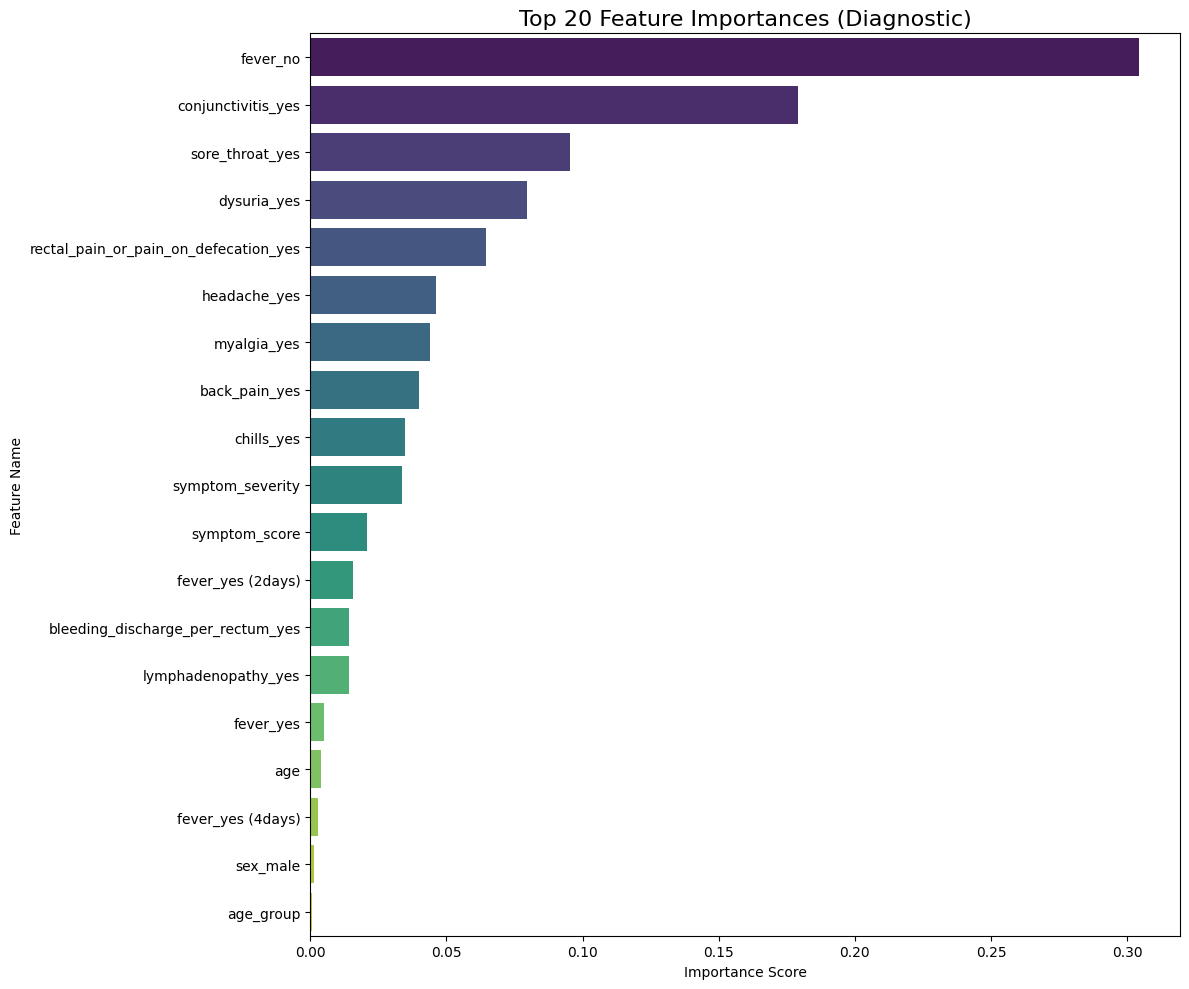


--- Fitur Paling Penting ---


,feature,importance
4,fever_no,0.304186
17,conjunctivitis_yes,0.179240
12,sore_throat_yes,0.095440
14,dysuria_yes,0.079451
15,rectal_pain_or_pain_on_defecation_yes,0.064533
8,headache_yes,0.046001
9,myalgia_yes,0.044150
10,back_pain_yes,0.039943
11,chills_yes,0.034660
2,symptom_severity,0.033576


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Latih model Random Forest sederhana HANYA untuk diagnostik
diagnostic_model = RandomForestClassifier(random_state=42)
diagnostic_model.fit(X_train_final, y_train_encoded)

# Buat DataFrame dari feature importances
feature_importances = pd.DataFrame({
    'feature': X_train_final.columns,
    'importance': diagnostic_model.feature_importances_
}).sort_values('importance', ascending=False)

# Tampilkan 20 fitur teratas
top_20_features = feature_importances.head(20)

# Visualisasikan
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=top_20_features, palette='viridis')
plt.title('Top 20 Feature Importances (Diagnostic)', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.show()

print("\n--- Fitur Paling Penting ---")
display(top_20_features)

--- Top 20 Fitur Paling Berhubungan dengan Target (Setelah Preprocessing) ---


,TARGET
TARGET,1.000000
fever_no,0.926753
conjunctivitis_yes,0.840540
sore_throat_yes,0.678848
rectal_pain_or_pain_on_defecation_yes,0.639037
back_pain_yes,0.559375
chills_yes,0.555670
fever_yes (2days),0.526227
symptom_severity,0.470309
headache_yes,0.446109


/tmp/ipython-input-2566097593.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_20_correlated.values, y=top_20_correlated.index, palette='rocket')


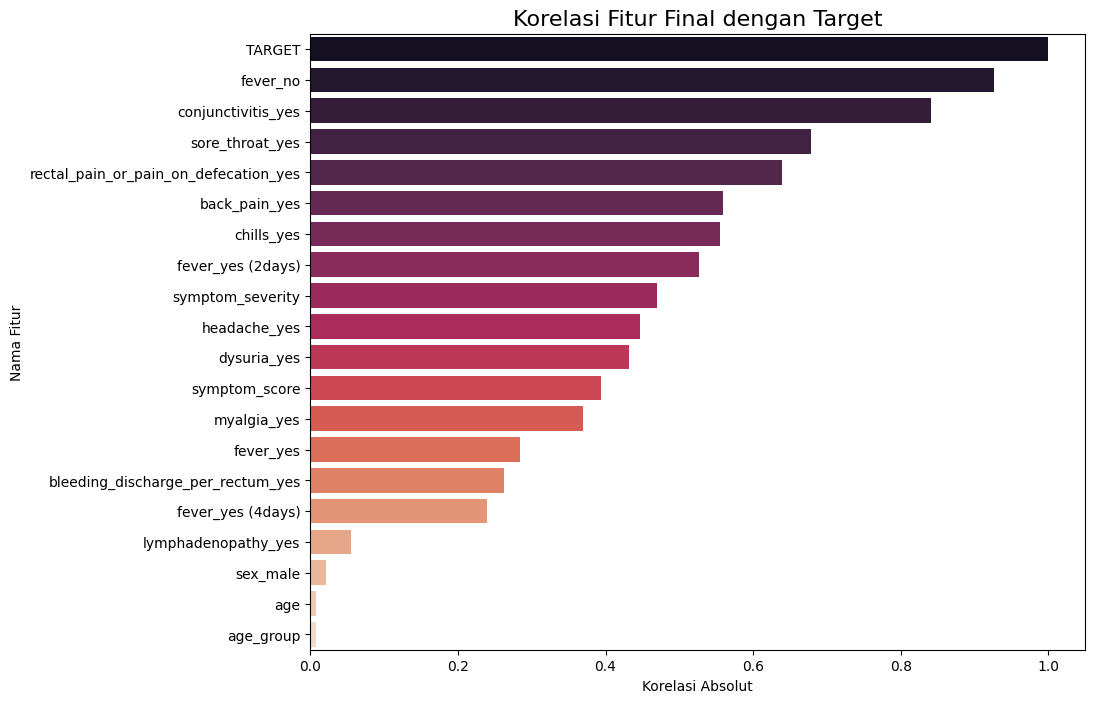

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Gabungkan data training final dengan targetnya untuk analisis korelasi
df_final_for_corr = X_train_final.copy()
df_final_for_corr['TARGET'] = y_train_encoded

# Hitung korelasi semua fitur terhadap TARGET
correlation_with_target = df_final_for_corr.corr()['TARGET'].abs().sort_values(ascending=False)

# Tampilkan 20 fitur yang paling berkorelasi dengan target
top_20_correlated = correlation_with_target.head(20)

print("--- Top 20 Fitur Paling Berhubungan dengan Target (Setelah Preprocessing) ---")
display(top_20_correlated.to_frame())

# Visualisasikan
plt.figure(figsize=(10, 8))
sns.barplot(x=top_20_correlated.values, y=top_20_correlated.index, palette='rocket')
plt.title('Korelasi Fitur Final dengan Target', fontsize=16)
plt.xlabel('Korelasi Absolut')
plt.ylabel('Nama Fitur')
plt.show()

In [13]:
# =============================================================================
# STEP 8: BASELINE MODEL TRAINING & EVALUATION (REVISED WITH MAXIMUM REGULARIZATION)
# =============================================================================
import pandas as pd
import time
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from IPython.display import display

# =============================================================================
# PASTIKAN VARIABEL INI SUDAH ADA DARI LANGKAH-LANGKAH SEBELUMNYA
# - X_train_final, X_validation_final
# - y_train_encoded, y_validation_encoded
# - positive_class_index (dari Step 7)
# =============================================================================

# --- 1. REVISI UTAMA: DEFINISI MODEL DENGAN REGULARISASI MAKSIMUM ---
print("\n" + "🏋️"*40)
print("Initializing models with MAXIMUM regularization to combat persistent overfitting...")
print("🏋️"*40)

models = {
    "Random Forest (Max Reg)": RandomForestClassifier(
        n_estimators=100,
        max_depth=4,            # SANGAT DANGKAL
        min_samples_leaf=15,    # Butuh 15 sampel untuk membuat keputusan
        max_features='sqrt',    # Hanya lihat sebagian kecil fitur per pohon
        random_state=42
    ),
    "XGBoost (Max Reg)": XGBClassifier(
        n_estimators=80,
        max_depth=2,            # SUPER DANGKAL
        learning_rate=0.01,     # Belajar SUPER LAMBAT
        gamma=1,                # Penalti MAKSIMAL
        subsample=0.6,          # Gunakan 60% data per pohon
        colsample_bytree=0.6,   # Gunakan 60% fitur per pohon
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    ),
    "CatBoost (Max Reg)": CatBoostClassifier(
        iterations=150,
        depth=3,                # SUPER DANGKAL
        learning_rate=0.01,     # Belajar SUPER LAMBAT
        l2_leaf_reg=7,          # Penalti L2 MAKSIMAL
        random_state=42,
        verbose=0
    )
}

# --- 2. FUNGSI EVALUASI (Tidak ada perubahan) ---
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name, feature_scenario, num_features):
    """Fungsi terpusat untuk melatih dan mengevaluasi model."""
    print("-" * 60)
    print(f"Training and Evaluating: {model_name} ({feature_scenario})")

    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    preds = model.predict(X_val)

    results = {
        "Model": f"{model_name} ({feature_scenario})",
        "Accuracy": accuracy_score(y_val, preds),
        "Precision": precision_score(y_val, preds, pos_label=positive_class_index, zero_division=0),
        "Recall": recall_score(y_val, preds, pos_label=positive_class_index, zero_division=0),
        "F1-Score": f1_score(y_val, preds, pos_label=positive_class_index, zero_division=0),
        "Training Time (s)": training_time,
        "Num Features": num_features
    }

    print(f"✅ Evaluation Complete. Accuracy: {results['Accuracy']:.4f}, F1-Score: {results['F1-Score']:.4f}")
    return results

# =============================================================================
# LANGKAH 8: Latih dan Evaluasi Model Baseline (Menggunakan SEMUA Fitur)
# =============================================================================
print("\n" + "🚀"*40)
print("STEP 8: TRAINING BASELINE MODELS (ON ALL FEATURES)")
print("🚀"*40)

baseline_results = []
for name, model in models.items():
    baseline_results.append(
        evaluate_model(model, X_train_final, y_train_encoded, X_validation_final, y_validation_encoded,
                       name, "Baseline", X_train_final.shape[1])
    )

# --- MENAMPILKAN TABEL HASIL ---
print("\n" + "📊"*40)
print("BASELINE MODEL PERFORMANCE COMPARISON")
print("📊"*40)

baseline_df = pd.DataFrame(baseline_results)
display(baseline_df.style.format(precision=4).background_gradient(cmap='viridis', subset=['Accuracy', 'F1-Score']))


🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️
Initializing models with MAXIMUM regularization to combat persistent overfitting...
🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️

🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
STEP 8: TRAINING BASELINE MODELS (ON ALL FEATURES)
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
------------------------------------------------------------
Training and Evaluating: Random Forest (Max Reg) (Baseline)
✅ Evaluation Complete. Accuracy: 0.9867, F1-Score: 0.9885
------------------------------------------------------------
Training and Evaluating: XGBoost (Max Reg) (Baseline)
✅ Evaluation Complete. Accuracy: 0.9867, F1-Score: 0.9885
------------------------------------------------------------
Training and Evaluating: CatBoost (Max Reg) (Baseline)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:51:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Evaluation Complete. Accuracy: 0.9867, F1-Score: 0.9885

📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊
BASELINE MODEL PERFORMANCE COMPARISON
📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊


,Model,Accuracy,Precision,Recall,F1-Score,Training Time (s),Num Features
0,Random Forest (Max Reg) (Baseline),0.9867,1.0000,0.9773,0.9885,0.1974,19
1,XGBoost (Max Reg) (Baseline),0.9867,1.0000,0.9773,0.9885,0.0761,19
2,CatBoost (Max Reg) (Baseline),0.9867,1.0000,0.9773,0.9885,0.3144,19


In [14]:
# =============================================================================
# STEP 9 (BARU): APPLYING IMPROVED GWO (IGWO) FEATURE SELECTION
# =============================================================================
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display

print("\\n" + "🧬"*40)
print("STEP 9: APPLYING IMPROVED GWO (IGWO) FEATURE SELECTION")
print("🧬"*40)

# Fitness function tetap sama, mengevaluasi subset fitur berdasarkan akurasi model
def fitness_function(feature_mask, X, y, model):
    selected_indices = np.where(np.array(feature_mask) == 1)[0]
    if len(selected_indices) == 0:
        return 0.0  # Jika tidak ada fitur terpilih, skor fitness 0

    X_subset = X.iloc[:, selected_indices]

    # Membagi data training lebih lanjut untuk evaluasi fitness internal yang cepat
    X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
        X_subset, y, test_size=0.25, stratify=y, random_state=42
    )

    model.fit(X_train_sub, y_train_sub)
    accuracy = model.score(X_val_sub, y_val_sub)

    # Penalti untuk jumlah fitur yang digunakan (mendorong solusi yang lebih sederhana)
    penalty = 0.01 * (len(selected_indices) / X.shape[1])

    return accuracy - penalty

# =============================================================================
# === REVISI UTAMA: KELAS IGWO DENGAN LOGIKA PEMBARUAN ALPHA, BETA, DELTA ===
# =============================================================================
class IGWOSelector:
    def __init__(self, fitness_func, num_wolves=20, max_iter=50):
        self.fitness_func = fitness_func
        self.num_wolves = num_wolves
        self.max_iter = max_iter
        # Model internal yang ringan untuk evaluasi fitness yang cepat
        self.eval_model = RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1)

    def run(self, X_train, y_train):
        num_features = X_train.shape[1]

        # 1. Inisialisasi populasi serigala (solusi biner)
        wolves = np.random.randint(0, 2, (self.num_wolves, num_features))

        # Inisialisasi posisi dan skor Alpha, Beta, Delta
        alpha_pos = np.zeros(num_features)
        alpha_score = -np.inf
        beta_pos = np.zeros(num_features)
        beta_score = -np.inf
        delta_pos = np.zeros(num_features)
        delta_score = -np.inf

        print("Memulai proses seleksi fitur dengan IGWO...")

        for t in range(self.max_iter):
            # Hitung fitness untuk setiap serigala
            fitness_scores = [self.fitness_func(wolf, X_train, y_train, self.eval_model) for wolf in wolves]

            # 2. MEKANISME "IMPROVED": Update Alpha, Beta, Delta
            # Bandingkan setiap serigala dengan pemimpin saat ini
            for i in range(self.num_wolves):
                if fitness_scores[i] > alpha_score:
                    # Geser pemimpin: alpha jadi beta, beta jadi delta
                    delta_score = beta_score
                    delta_pos = beta_pos.copy()
                    beta_score = alpha_score
                    beta_pos = alpha_pos.copy()
                    # Alpha baru
                    alpha_score = fitness_scores[i]
                    alpha_pos = wolves[i].copy()
                elif fitness_scores[i] > beta_score:
                    # Geser pemimpin: beta jadi delta
                    delta_score = beta_score
                    delta_pos = beta_pos.copy()
                    # Beta baru
                    beta_score = fitness_scores[i]
                    beta_pos = wolves[i].copy()
                elif fitness_scores[i] > delta_score:
                    # Delta baru
                    delta_score = fitness_scores[i]
                    delta_pos = wolves[i].copy()

            a = 2 - t * (2 / self.max_iter)  # Parameter 'a' menurun linear dari 2 ke 0

            # 3. Update posisi semua serigala berdasarkan pemimpin
            for i in range(self.num_wolves):
                r1, r2 = np.random.rand(2)
                A1 = 2 * a * r1 - a
                C1 = 2 * r2
                D_alpha = np.abs(C1 * alpha_pos - wolves[i])
                X1 = alpha_pos - A1 * D_alpha

                r1, r2 = np.random.rand(2)
                A2 = 2 * a * r1 - a
                C2 = 2 * r2
                D_beta = np.abs(C2 * beta_pos - wolves[i])
                X2 = beta_pos - A2 * D_beta

                r1, r2 = np.random.rand(2)
                A3 = 2 * a * r1 - a
                C3 = 2 * r2
                D_delta = np.abs(C3 * delta_pos - wolves[i])
                X3 = delta_pos - A3 * D_delta

                # Posisi baru dihitung sebagai rata-rata pergerakan
                new_position_continuous = (X1 + X2 + X3) / 3.0

                # Konversi ke posisi biner menggunakan fungsi sigmoid
                sigmoid = 1 / (1 + np.exp(-10 * (new_position_continuous - 0.5)))
                wolves[i] = (sigmoid > np.random.rand(num_features)).astype(int)

            if (t + 1) % 5 == 0:
                print(f"  - Iterasi {t+1}/{self.max_iter} | Best Fitness Sejauh Ini: {alpha_score:.4f}")

        # Kembalikan fitur-fitur terbaik yang ditemukan oleh Alpha wolf
        best_features_indices = np.where(alpha_pos == 1)[0]
        return X_train.columns[best_features_indices].tolist()

# =============================================================================
# EKSEKUSI IGWO
# =============================================================================
# Gunakan data training yang sudah di-preprocessing (X_train_final)
# Targetnya adalah y_train_encoded

igwo_selector = IGWOSelector(fitness_function, num_wolves=20, max_iter=50)
start_time = time.time()
best_features_igwo = igwo_selector.run(X_train_final, y_train_encoded)
end_time = time.time()

print(f"\\n✅ IGWO selesai dalam {end_time - start_time:.2f} detik.")
print(f"   - Fitur terpilih ({len(best_features_igwo)}): {best_features_igwo}")

# Siapkan dataset baru yang hanya berisi fitur-fitur pilihan IGWO
X_train_selected = X_train_final[best_features_igwo]
X_validation_selected = X_validation_final[best_features_igwo]
X_test_selected = X_test_final[best_features_igwo]

print(f"\\n   - Ukuran baru X_train_selected: {X_train_selected.shape}")
print("="*80)

\n🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬
STEP 9: APPLYING IMPROVED GWO (IGWO) FEATURE SELECTION
🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬
Memulai proses seleksi fitur dengan IGWO...
  - Iterasi 5/50 | Best Fitness Sejauh Ini: 0.9984
  - Iterasi 10/50 | Best Fitness Sejauh Ini: 0.9989
  - Iterasi 15/50 | Best Fitness Sejauh Ini: 0.9989
  - Iterasi 20/50 | Best Fitness Sejauh Ini: 0.9989
  - Iterasi 25/50 | Best Fitness Sejauh Ini: 0.9989
  - Iterasi 30/50 | Best Fitness Sejauh Ini: 0.9989
  - Iterasi 35/50 | Best Fitness Sejauh Ini: 0.9989
  - Iterasi 40/50 | Best Fitness Sejauh Ini: 0.9989
  - Iterasi 45/50 | Best Fitness Sejauh Ini: 0.9989
  - Iterasi 50/50 | Best Fitness Sejauh Ini: 0.9989
\n✅ IGWO selesai dalam 62.81 detik.
   - Fitur terpilih (2): ['fever_no', 'back_pain_yes']
\n   - Ukuran baru X_train_selected: (350, 2)


In [15]:
# =============================================================================
# STEP 10 & 11: RE-TRAIN ON IGWO FEATURES & FINAL TEST (FIXED)
# =============================================================================
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from IPython.display import display

print("\\n" + "🏆"*40)
print("STEP 10: RE-TRAINING ON IGWO-SELECTED FEATURES")
print("🏆"*40)

# 'models' sudah didefinisikan di Step 8
# 'baseline_results' sudah dibuat di Step 8
# 'evaluate_model' sudah didefinisikan di Step 8
# 'X_train_selected' dan 'X_validation_selected' dibuat di Step 9

igwo_results = []
for name, model in models.items():
    igwo_results.append(
        evaluate_model(model,
                       X_train_selected,
                       y_train_encoded,
                       X_validation_selected,
                       y_validation_encoded,
                       name,
                       "IGWO",
                       X_train_selected.shape[1])
    )

# --- Gabungkan dan Tampilkan Tabel Perbandingan Akhir ---
final_comparison_df = pd.concat([pd.DataFrame(baseline_results), pd.DataFrame(igwo_results)], ignore_index=True)

print("\\n" + "📊"*40)
print("FINAL RESULTS COMPARISON ON VALIDATION SET")
print("📊"*40)
display(final_comparison_df.sort_values(by="F1-Score", ascending=False).style.format(precision=4).background_gradient(cmap='Greens', subset=['Accuracy', 'F1-Score']))

# =============================================================================
# STEP 11: FINAL TEST ON UNSEEN DATA (LOGIC CORRECTED)
# =============================================================================
print("\\n" + "🏅"*40); print("STEP 11: FINAL TEST ON UNSEEN DATA"); print("🏅"*40)

# Cari model terbaik dari tabel perbandingan akhir
best_model_row = final_comparison_df.loc[final_comparison_df['F1-Score'].idxmax()]
best_model_full_name = best_model_row['Model']
print(f"🏆 Best performing model on validation set: {best_model_full_name}")

# Ambil objek model yang sesuai dari dictionary 'models'
model_key = best_model_full_name.replace(" (Baseline)", "").replace(" (IGWO)", "")
final_model = models[model_key]

# --- FIX: Siapkan set data yang KONSISTEN untuk digabungkan dan diuji ---
if "IGWO" in best_model_full_name:
    print("   - Using features selected by IGWO for the final training and test.")
    X_train_to_combine = X_train_selected
    X_validation_to_combine = X_validation_selected # Gunakan set validasi yang sudah diseleksi fiturnya
    X_test_for_final_eval = X_test_selected
else:
    print("   - Using all baseline features for the final training and test.")
    X_train_to_combine = X_train_final
    X_validation_to_combine = X_validation_final # Gunakan set validasi yang lengkap
    X_test_for_final_eval = X_test_final

# Latih ulang model terbaik pada data training + validation yang digabungkan
print("   - Re-fitting the best model on the combined training and validation data...")

# Menggunakan pd.concat untuk menggabungkan DataFrame, lebih aman
combined_X = pd.concat([X_train_to_combine, X_validation_to_combine])
combined_y = np.concatenate([y_train_encoded, y_validation_encoded])

final_model.fit(combined_X, combined_y)

# Lakukan prediksi pada data tes yang belum pernah dilihat
final_preds = final_model.predict(X_test_for_final_eval)

print("\\n--- Final Performance on Unseen Test Set ---")
print(classification_report(y_test_encoded, final_preds, target_names=[str(c) for c in le.classes_], zero_division=0))

print("\\n" + "🏁"*60); print("MODELING & EXPERIMENTATION PHASE COMPLETE!"); print("🏁"*60)

\n🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆
STEP 10: RE-TRAINING ON IGWO-SELECTED FEATURES
🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆
------------------------------------------------------------
Training and Evaluating: Random Forest (Max Reg) (IGWO)
✅ Evaluation Complete. Accuracy: 0.9867, F1-Score: 0.9885
------------------------------------------------------------
Training and Evaluating: XGBoost (Max Reg) (IGWO)
✅ Evaluation Complete. Accuracy: 0.9867, F1-Score: 0.9885
------------------------------------------------------------
Training and Evaluating: CatBoost (Max Reg) (IGWO)
✅ Evaluation Complete. Accuracy: 0.9867, F1-Score: 0.9885
\n📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊
FINAL RESULTS COMPARISON ON VALIDATION SET
📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:52:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Model,Accuracy,Precision,Recall,F1-Score,Training Time (s),Num Features
0,Random Forest (Max Reg) (Baseline),0.9867,1.0000,0.9773,0.9885,0.1974,19
1,XGBoost (Max Reg) (Baseline),0.9867,1.0000,0.9773,0.9885,0.0761,19
2,CatBoost (Max Reg) (Baseline),0.9867,1.0000,0.9773,0.9885,0.3144,19
3,Random Forest (Max Reg) (IGWO),0.9867,1.0000,0.9773,0.9885,0.1675,2
4,XGBoost (Max Reg) (IGWO),0.9867,1.0000,0.9773,0.9885,0.0200,2
5,CatBoost (Max Reg) (IGWO),0.9867,1.0000,0.9773,0.9885,0.0729,2


\n🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅
STEP 11: FINAL TEST ON UNSEEN DATA
🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅
🏆 Best performing model on validation set: Random Forest (Max Reg) (Baseline)
   - Using all baseline features for the final training and test.
   - Re-fitting the best model on the combined training and validation data...
\n--- Final Performance on Unseen Test Set ---
              precision    recall  f1-score   support

    negative       0.97      1.00      0.98        30
    positive       1.00      0.98      0.99        45

    accuracy                           0.99        75
   macro avg       0.98      0.99      0.99        75
weighted avg       0.99      0.99      0.99        75

\n🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁
MODELING & EXPERIMENTATION PHASE COMPLETE!
🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁


In [16]:
# =============================================================================
# LANGKAH 11: UJI FINAL pada Data Tak Terlihat (Unseen Test Data) - DENGAN FIX
# =============================================================================
print("\n" + "🏅"*40); print("STEP 11: FINAL TEST ON UNSEEN DATA"); print("🏅"*40)

# Cari model terbaik berdasarkan F1-Score di validation set
# Pastikan final_comparison_df sudah ada dari langkah sebelumnya
best_model_row = final_comparison_df.loc[final_comparison_df['F1-Score'].idxmax()]
best_model_full_name = best_model_row['Model']
print(f"🏆 Best performing model on validation set: {best_model_full_name}")

# =============================================================================
# === PERBAIKAN LOGIKA PENCARIAN KUNCI MODEL ===
# =============================================================================
# Hapus akhiran '(Baseline)' atau '(IGWO)' untuk mendapatkan kunci dictionary yang benar
model_key = best_model_full_name.replace(" (Baseline)", "").replace(" (IGWO)", "")

# Ambil objek model yang sudah dilatih dari dictionary models
final_model = models[model_key]
print(f"   - Menggunakan objek model dari kunci: '{model_key}'")
# =============================================================================

# Siapkan data yang benar untuk model terbaik (Baseline atau IGWO)
if "IGWO" in best_model_full_name:
    print("   - ...using features selected by IGWO for the final test.")
    X_train_for_final_fit = X_train_selected
    X_test_for_final_eval = X_test_selected
else:
    print("   - ...using all baseline features for the final test.")
    X_train_for_final_fit = X_train_final
    X_test_for_final_eval = X_test_final

# Latih ulang model terbaik HANYA pada data training final yang sesuai
print("   - Re-fitting the best model on the appropriate training data...")
final_model.fit(X_train_for_final_fit, y_train_encoded)

# Lakukan prediksi pada data tes yang belum pernah dilihat
final_preds = final_model.predict(X_test_for_final_eval)

print("\n--- Final Performance on Unseen Test Set ---")
# Pastikan 'le' (LabelEncoder dari Step 7) tersedia untuk mendapatkan nama kelas
print(classification_report(y_test_encoded, final_preds, target_names=[str(c) for c in le.classes_], zero_division=0))
print("\n" + "🏁"*60); print("MODELING & EXPERIMENTATION PHASE COMPLETE!"); print("🏁"*60)


🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅
STEP 11: FINAL TEST ON UNSEEN DATA
🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅
🏆 Best performing model on validation set: Random Forest (Max Reg) (Baseline)
   - Menggunakan objek model dari kunci: 'Random Forest (Max Reg)'
   - ...using all baseline features for the final test.
   - Re-fitting the best model on the appropriate training data...

--- Final Performance on Unseen Test Set ---
              precision    recall  f1-score   support

    negative       0.97      1.00      0.98        30
    positive       1.00      0.98      0.99        45

    accuracy                           0.99        75
   macro avg       0.98      0.99      0.99        75
weighted avg       0.99      0.99      0.99        75


🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁
MODELING & EXPERIMENTATION PHASE COMPLETE!
🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁
